In [1]:
# Clustering of timeseries data
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import umap
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from VisualizationFunctions import plot_by_factor, AnalyzeClusters
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from dynamic_time_warping import Preprocessing
import statsmodels.api as sm
from statsmodels.formula.api import ols
%matplotlib inline

In [2]:
print('Reading in the data...')
agg = pd.read_csv('sku_labels.csv')
df = pd.read_csv('extracted_features.csv')
sales = pd.read_csv('aggregate_products.csv')
product_sales = pd.read_csv('aggregate_products.csv')
df.dropna(axis=1, inplace=True)

scale = StandardScaler()
skus = df['id']
df.set_index('id', inplace=True)
X = scale.fit_transform(df)
names = df.columns

Reading in the data...


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
pp = Preprocessing()

In [5]:
pivot_table = pp.pivot_table(product_sales)
sorted_df = pp.sort_nas(pivot_table)
pp.make_diff_length_list(sorted_df)

Manipulate and pivot table...
There are 1122 products with less than 50% entries


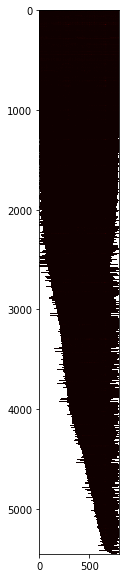

In [6]:
pp.plot_nas(sorted_df)

In [7]:
sorted_df['nan'] = sorted_df['2016-03-01'].apply(np.isnan)
no_nans = sorted_df[sorted_df['nan'] == False].drop('nan', axis=1)
nans = sorted_df[sorted_df['nan'] == True].drop('nan', axis=1)

In [8]:
nans = df.loc[list(nans.index),:]
no_nans = df.loc[list(no_nans.index),:]

In [8]:
scale = RobustScaler()
skus = nans.index
X = scale.fit_transform(nans)
names = df.columns

In [3]:
from sklearn.decomposition import PCA

In [4]:
pca = PCA(n_components=50)
X_dim = pca.fit_transform(X)

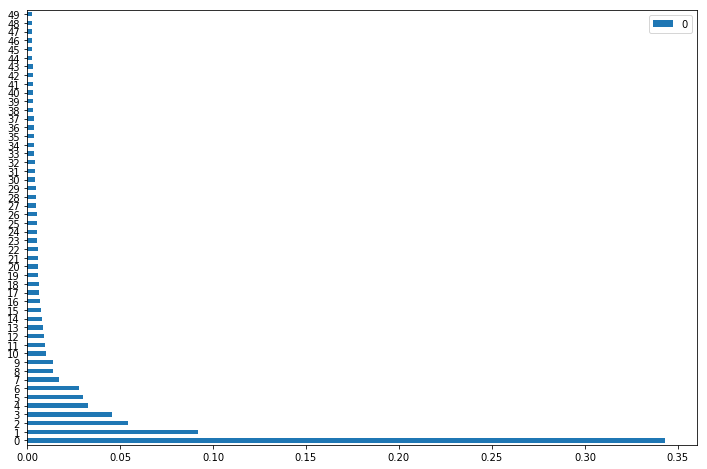

In [5]:
pd.DataFrame(pca.explained_variance_ratio_).plot(kind='barh', figsize=(12,8))

## Dimentionality Reduction

In [6]:
print('Running UMAP Dimentionality Reduction...')
um = umap.UMAP(n_neighbors=30, min_dist=0.0)
umaps = um.fit_transform(X_dim)

Running UMAP Dimentionality Reduction...


In [7]:
#Merge tsne coordinates onto original df with sku_keys
plot_df = pd.DataFrame(umaps).join(df.reset_index())

#Merge above tsne and features table to sku_key and categories
plot_df['sku_key'] = plot_df['id'].astype(int)
agg['sku_key'] = agg['sku_key'].astype(int)
plot_df = plot_df.merge(agg, how='left', on='sku_key')

colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue',
        'blue', 'red', 'green', 'yellow', 'brown', 'violet',
        'orchid', 'olive', 'black', 'grey', 'purple',
        'lime', 'darkblue', 'darkred', 'darkgreen',
        'tomato', 'lightgreen', 'lightblue', 'darkorange']

In [8]:
#print('Running t-SNE Dimentionality Reduction...')
#dimred = TSNE(2, n_iter=2000)
#tsnes = dimred.fit_transform(X)
#
##Merge tsne coordinates onto original df with sku_keys
#plot_df = pd.DataFrame(tsnes).join(df.reset_index())
#
##Merge above tsne and features table to sku_key and categories
#plot_df['sku_key'] = plot_df['id'].astype(int)
#agg['sku_key'] = agg['sku_key'].astype(int)
#plot_df = plot_df.merge(agg, how='left', on='sku_key')
#
#colors=['b', 'r', 'g', 'y', 'm', 'orange', 'gold', 'skyblue']

In [9]:
plot_df.head()

,0,1,id,sales__abs_energy,sales__absolute_sum_of_changes,"sales__agg_autocorrelation__f_agg_""mean""","sales__agg_autocorrelation__f_agg_""median""","sales__agg_autocorrelation__f_agg_""var""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""intercept""","sales__agg_linear_trend__f_agg_""max""__chunk_len_10__attr_""rvalue""",...,sales__value_count__value_inf,sales__value_count__value_nan,sales__variance,sales__variance_larger_than_standard_deviation,sku_key,sku_department,sku_subdepartment,sku_category,sku_subcategory,sku_label
0,6.995901,8.927888,28,458.0,224.0,0.001593,-0.011081,0.002407,1.307929,-0.017107,...,0.0,0.0,0.583464,0.0,28,TY,06,063,20G,DRGI
1,11.346299,7.332155,34,2470.0,1039.0,-0.005049,-0.004214,0.000957,4.032407,-0.068870,...,0.0,0.0,2.110831,1.0,34,TY,4,11,35A,DINO
2,13.179401,6.932209,100,141080.0,5956.0,-0.009453,-0.004421,0.001920,22.423148,0.035381,...,0.0,0.0,43.834622,1.0,100,BH,02,38,C09,NUK
3,7.379568,9.908269,101,37.0,70.0,-0.007104,-0.001491,0.001270,0.237838,0.203768,...,0.0,0.0,0.049186,0.0,101,BH,02,038,123,KORBEL
4,8.023128,8.542156,102,301.0,289.0,-0.009185,-0.011381,0.000753,1.221835,0.055354,...,0.0,0.0,0.344670,0.0,102,BH,02,038,123,KORBEL


In [10]:
plot_df.shape

(5451, 466)

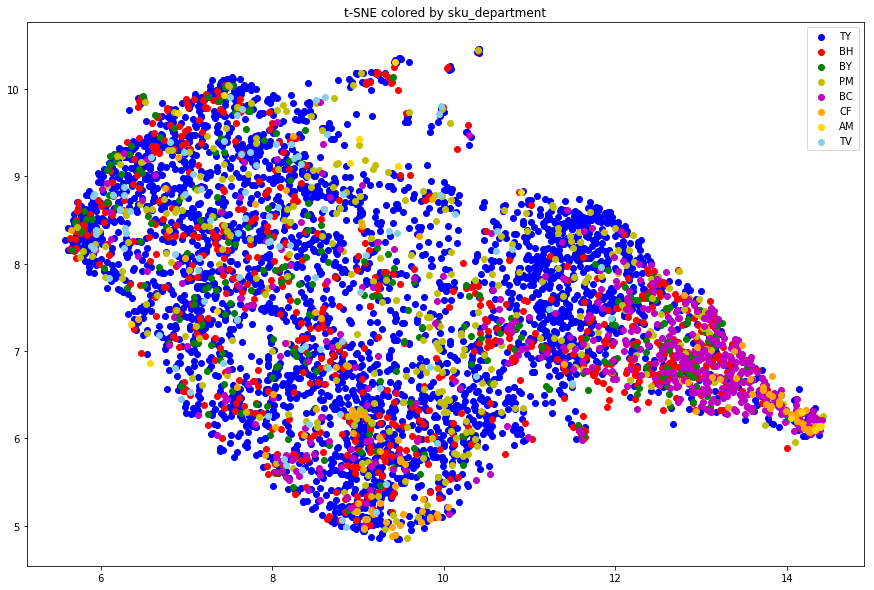

In [11]:
plot_by_factor(plot_df, 'sku_department', colors, showplot=True)

In [12]:
sales_df = sales.groupby('sku_key').sum().reset_index()[['sku_key', 'sales']].merge(plot_df, on='sku_key')[['sku_key', 'sales', 0,1]]
sales_df['sales_log'] = np.log10(sales_df['sales'])

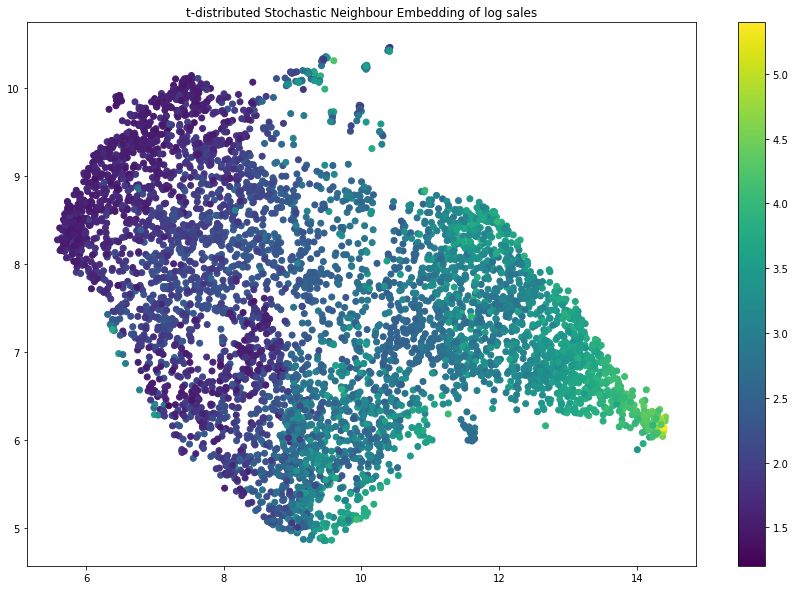

In [13]:
f, ax = plt.subplots(figsize=(15,10))
sc = ax.scatter(sales_df[0], sales_df[1], c=sales_df['sales_log'], cmap='viridis')
plt.colorbar(sc)
ax.set_title('t-distributed Stochastic Neighbour Embedding of log sales')
plt.show()
f.savefig('./images/cumulative_sales.png')

## SOM

In [14]:
colors = ['darkblue', 'tomato', 'orchid', 'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r', 'brown']
run_cont = ['sales', 'selling_price', 'avg_discount']
run_cats = ['sku_department', 'sku_subdepartment', 'sku_category', 'sku_subcategory']

In [15]:
som_clus = pd.read_csv('som_clusters.csv')
som_clus.columns = ['sku_key', 'cluster']

analyze_som = AnalyzeClusters()
df_dict = analyze_som.make_dataset(product_sales, som_clus)

## You have to write functions to make these plots

In [ ]:
analyze_som.

In [113]:
df_dict.keys()


dict_keys(['cluster_5', 'cluster_4', 'cluster_3', 'cluster_0', 'cluster_1', 'cluster_2'])

In [118]:
for i, j in df_dict.items():
    print(i, len(j))

cluster_5 1293758
cluster_4 1455536
cluster_3 384280
cluster_0 127446
cluster_1 13340
cluster_2 3975


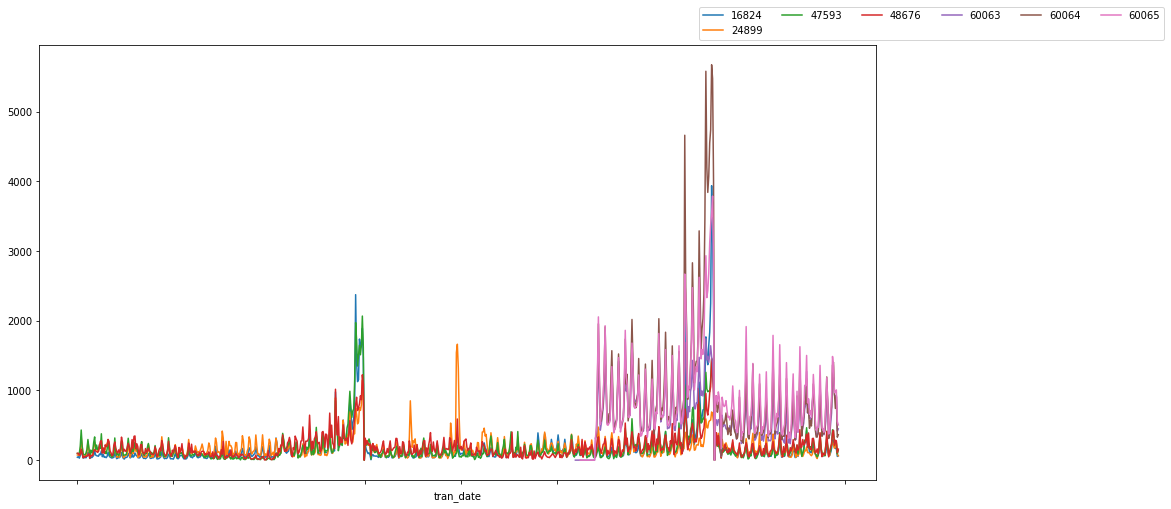

In [152]:
pd.pivot_table(df_dict['cluster_2'], values='sales', columns='tran_date', index='sku_key').T.plot(figsize=(15,8))
plt.legend(bbox_to_anchor=(1.35, 1.1), ncol=6)

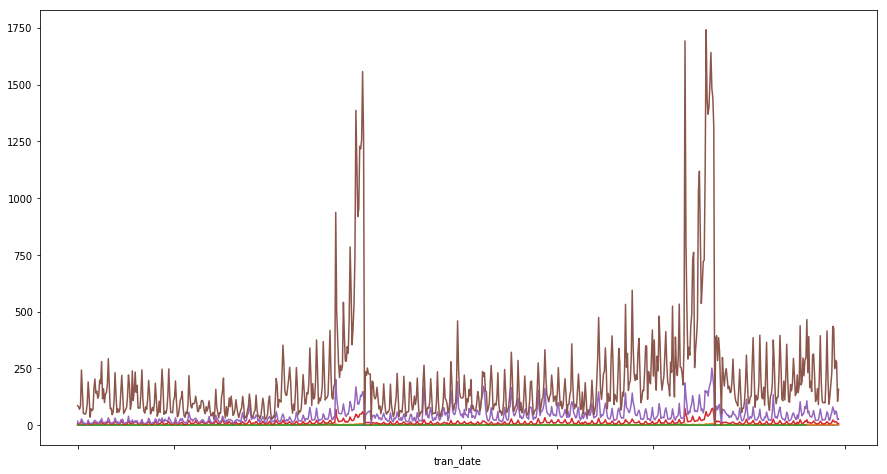

In [150]:
for i, j in df_dict.items():
    j.groupby('tran_date').median()['sales'].plot(figsize=(15,8))

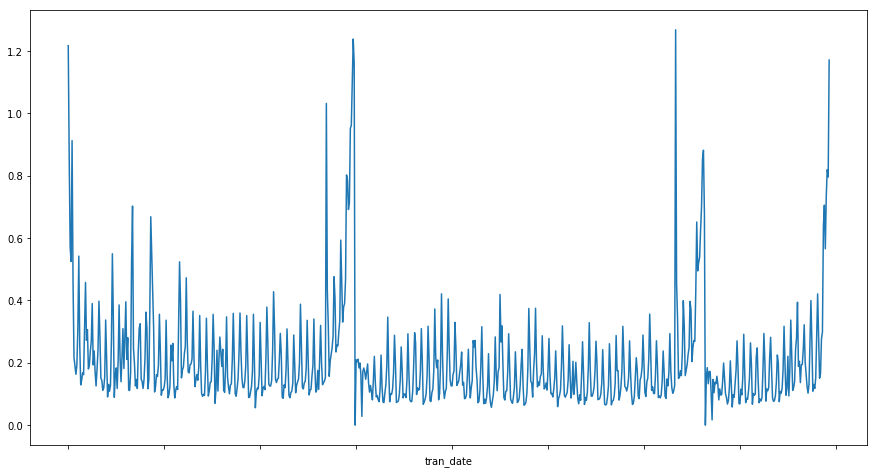

In [151]:
df_dict['cluster_5'].groupby('tran_date').mean()['sales'].plot(figsize=(15,8))

---

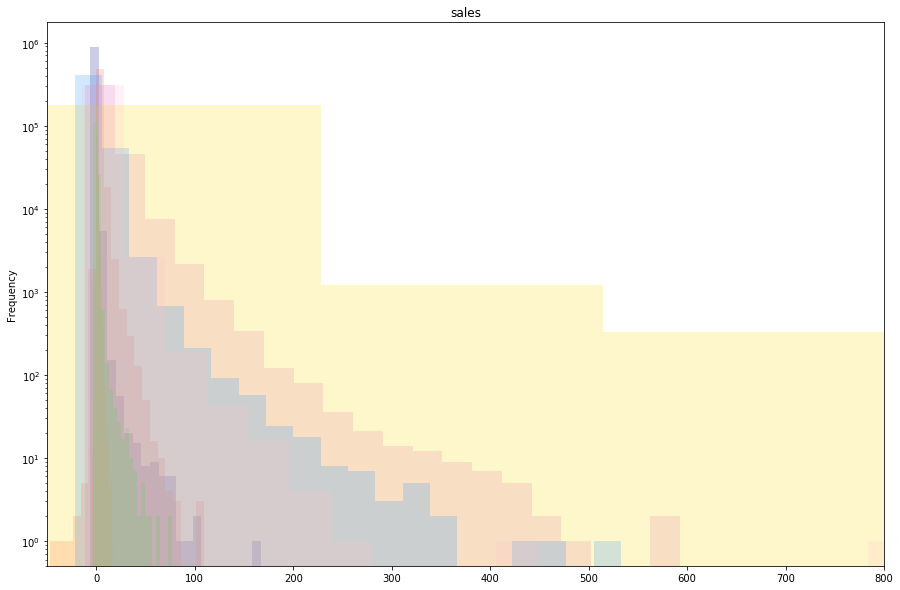

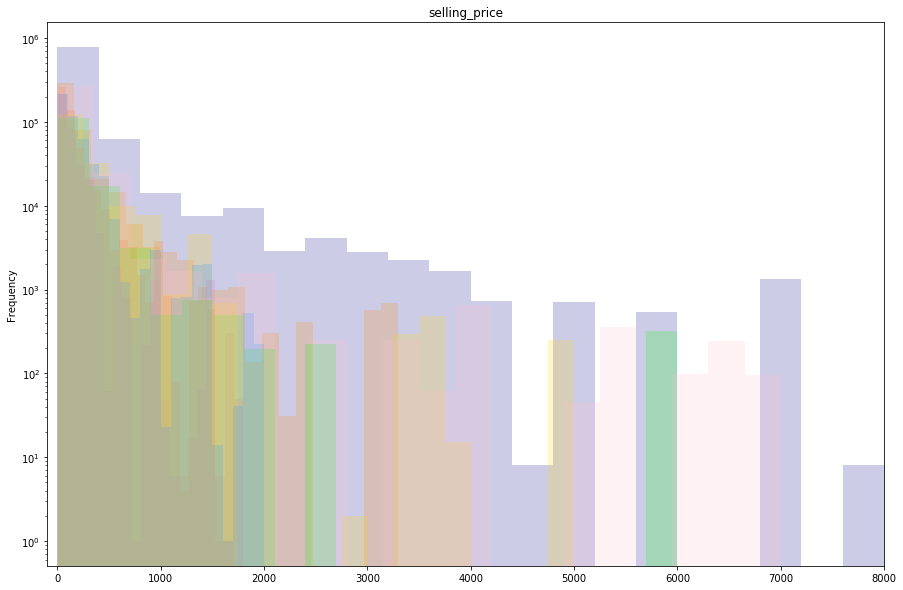

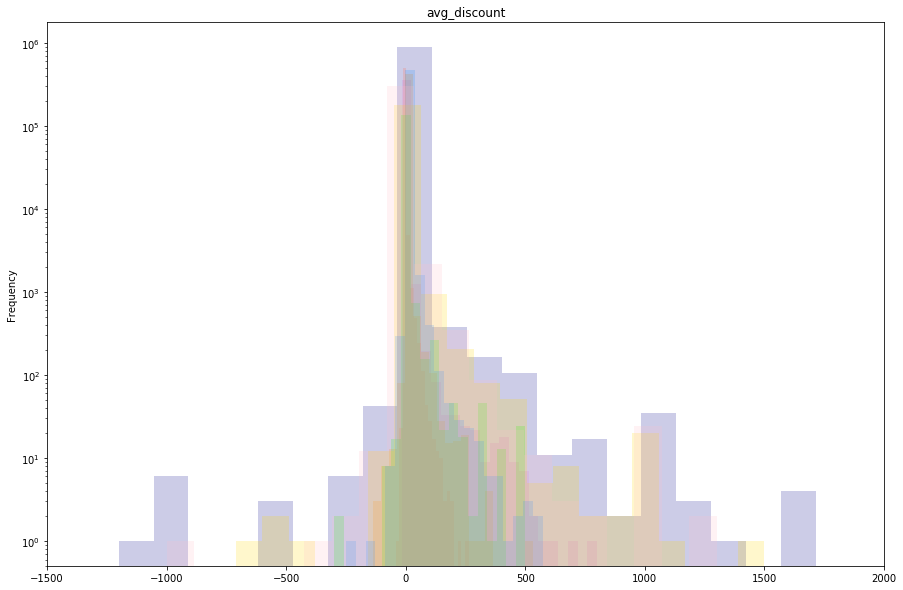

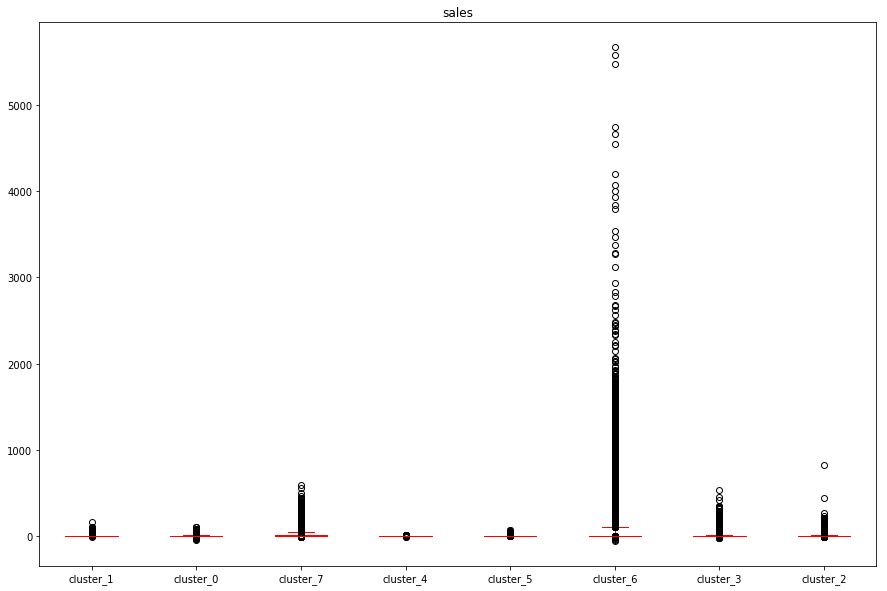

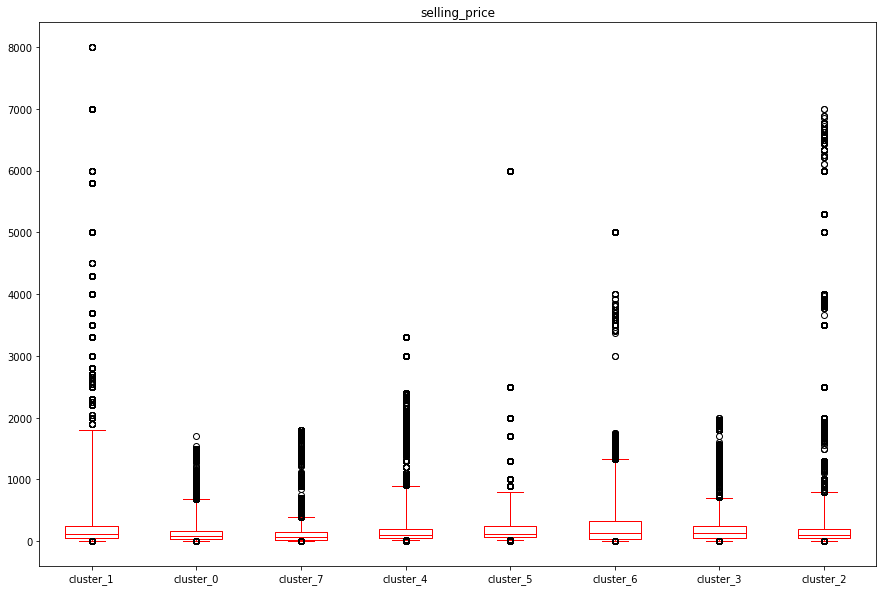

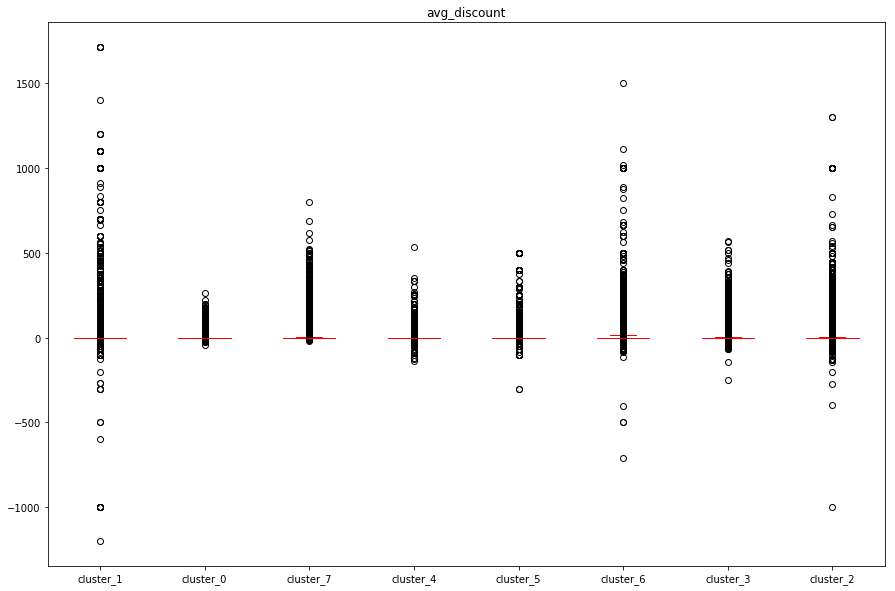

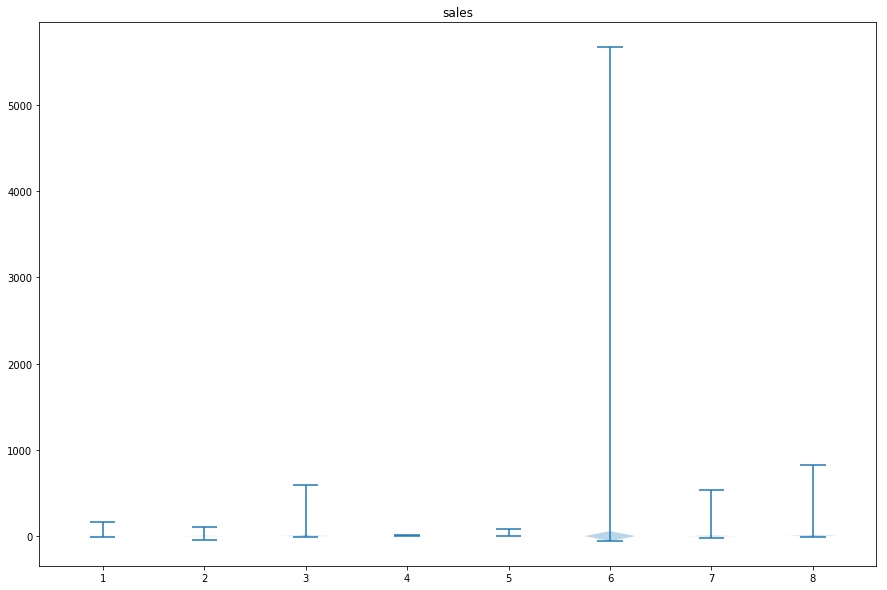

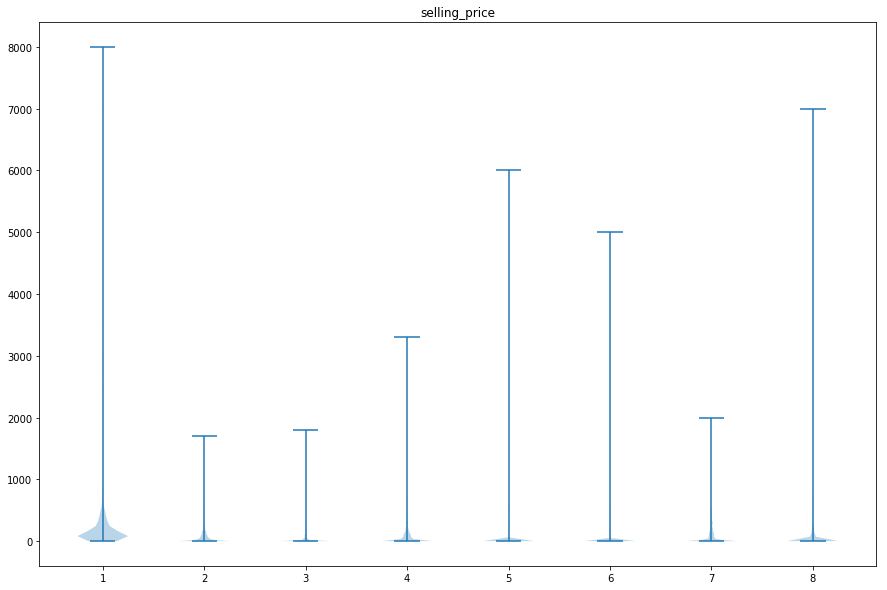

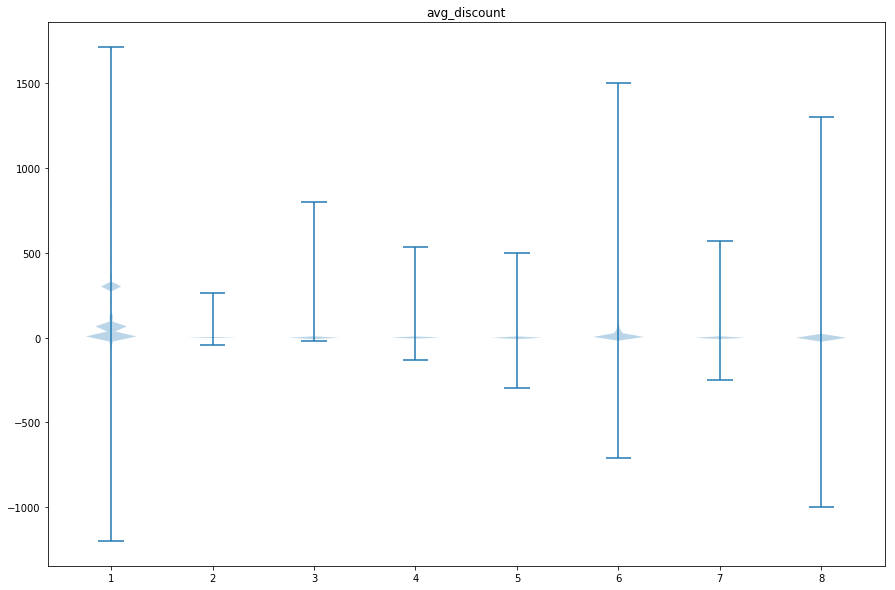



 sku_department


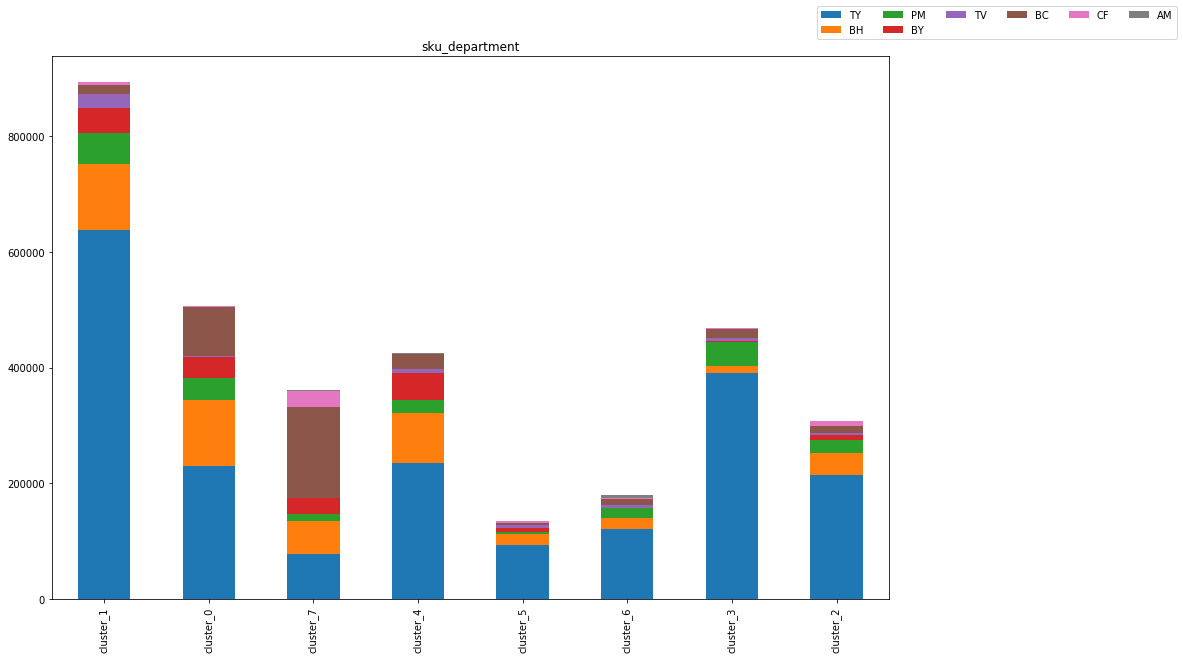



 sku_subdepartment


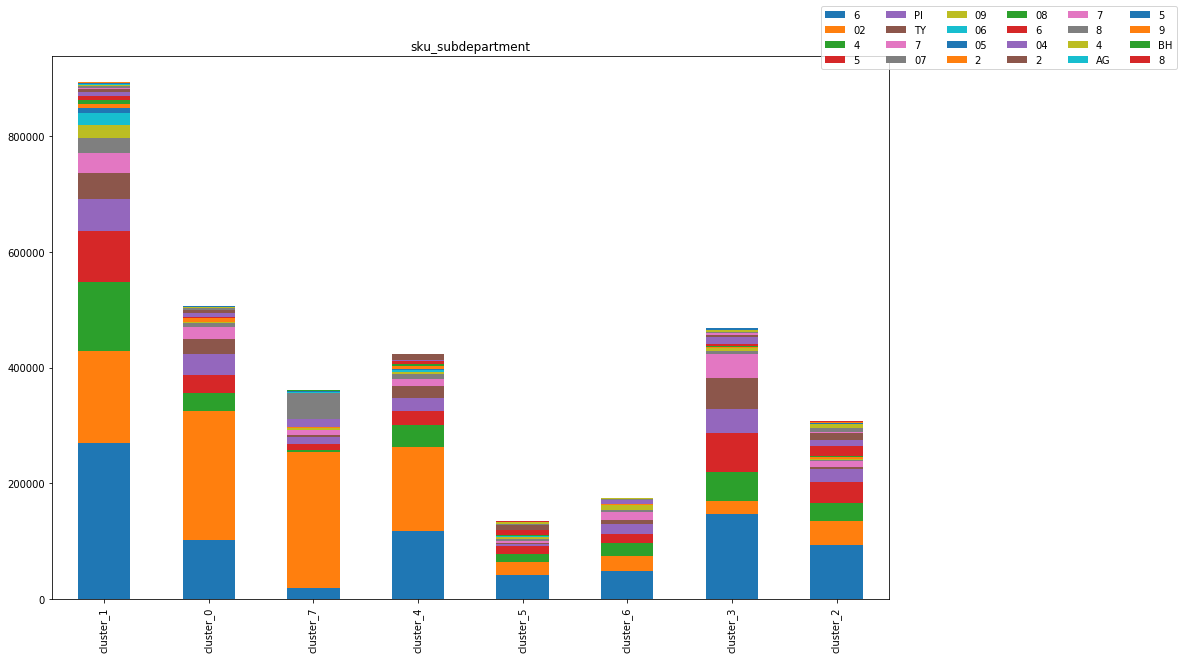



 sku_category


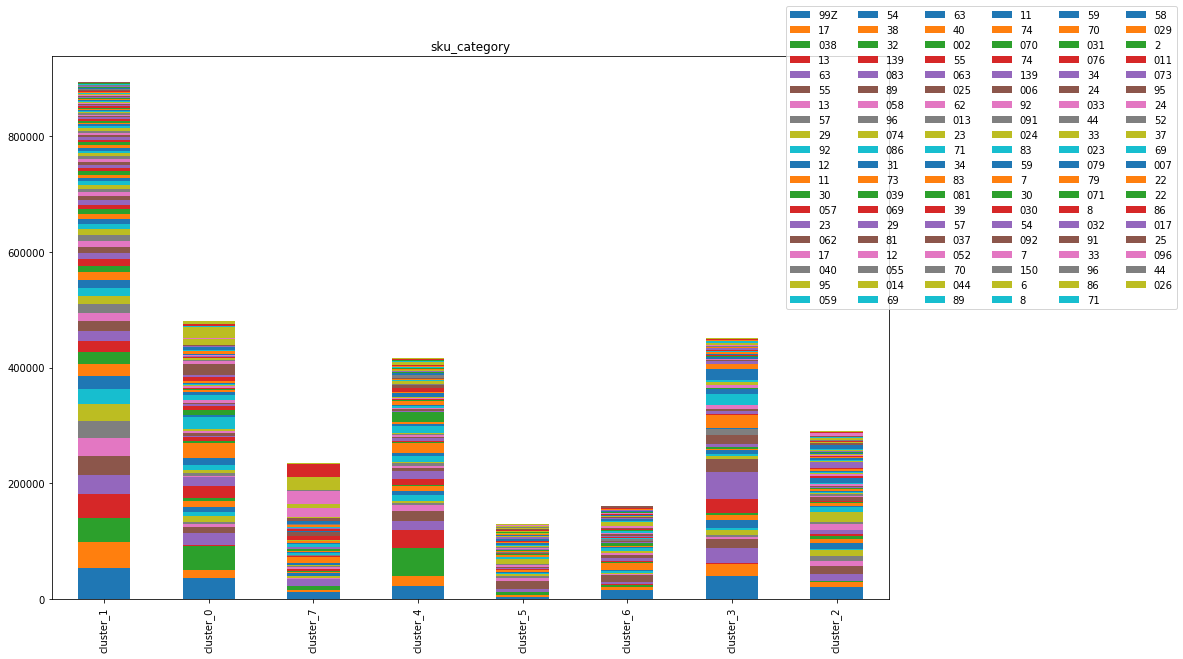



 sku_subcategory


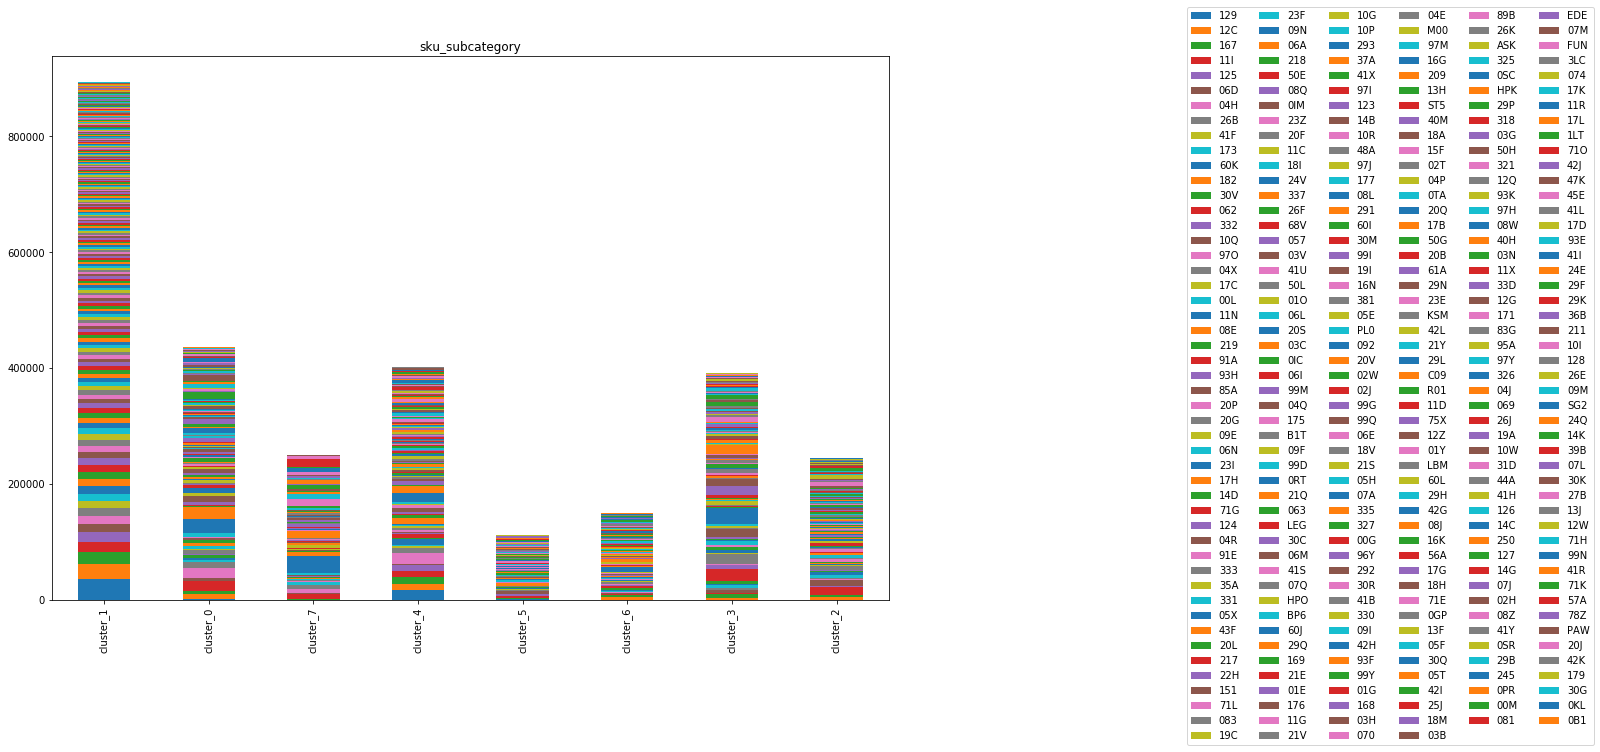

In [81]:
analyze_som.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_som.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_som.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_som.plot_cluster_categorical(df_dict, run_cats, True)

In [13]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq         df             F  PR(>F)
cluster   9.306368e+05        5.0  17924.944399     0.0
Residual  1.738394e+07  1674156.0           NaN     NaN 

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_0 cluster_1 -1.3519  -1.3846 -1.3191  True 
cluster_0 cluster_2 -1.1937  -1.2214 -1.1659  True 
cluster_0 cluster_3  0.4584   0.4308  0.486   True 
cluster_0 cluster_4 -1.4178  -1.4424 -1.3932  True 
cluster_0 cluster_5 -0.5868  -0.6233 -0.5503  True 
cluster_1 cluster_2  0.1582   0.1284  0.188   True 
cluster_1 cluster_3  1.8103   1.7807  1.8398  True 
cluster_1 cluster_4  -0.066  -0.0928 -0.0391  True 
cluster_1 cluster_5  0.7651   0.727   0.8031  True 
cluster_2 cluster_3  1.6521   1.6281  1.676   True 
cluster_2 cluster_4 -0.2241  -0.2446 -0.2037  True 
cluster_2 cluster_5  0.6069   0.573   0.6407  True 
cluster_3 cluster_4 -1.8762  -1.8964  -1

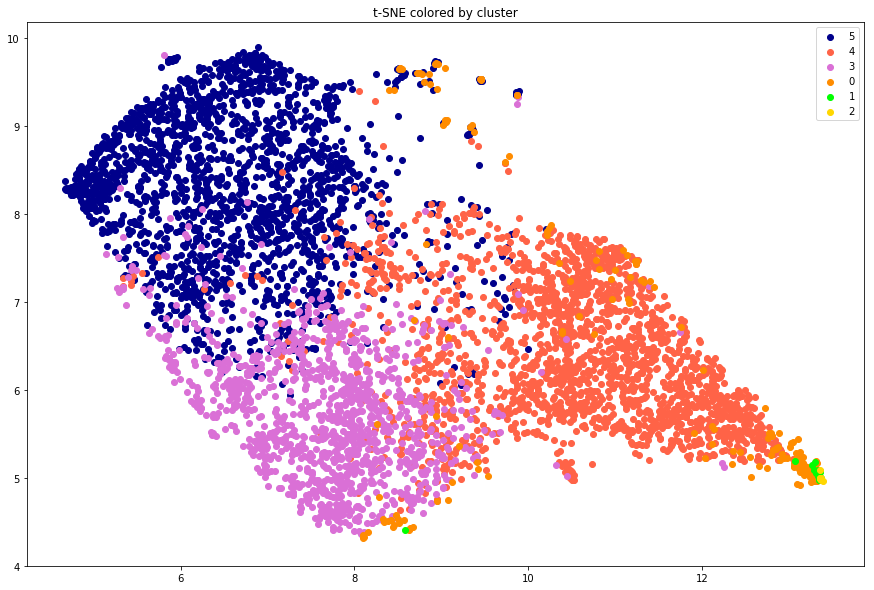

In [87]:
som_tsne = plot_df.merge(som_clus, left_on='id', right_on='sku_key')

plot_by_factor(som_tsne, 'cluster', colors, False)

In [15]:
som_sales_df = sales_df.merge(som_clus, on='sku_key')
som_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,22.483915,25.307186,175,2.075547,4
1,34,122,18.813700,5.753131,175,2.086360,4
2,100,1530,-53.056255,13.143605,2000,3.184691,3
3,152,44,48.061001,-24.166861,25,1.643453,4
4,182,914,-25.316551,24.063744,775,2.960946,3


cluster 4
1113


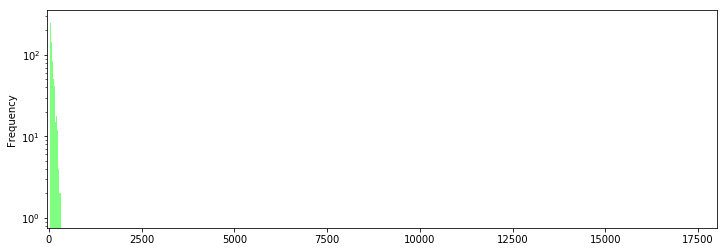

cluster 3
464


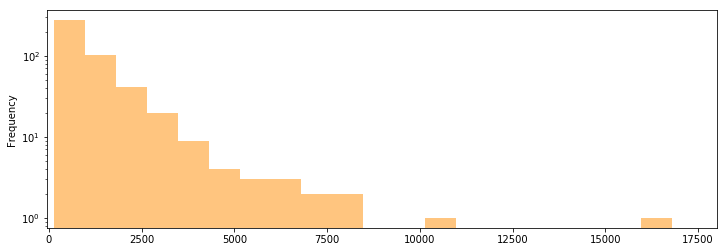

cluster 2
441


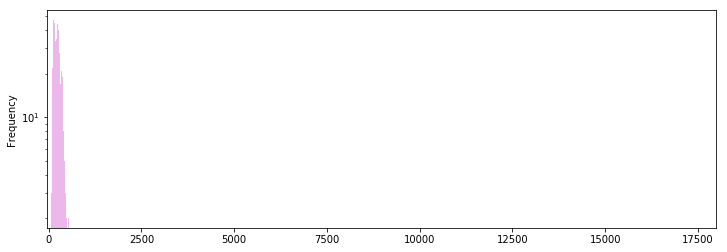

cluster 0
286


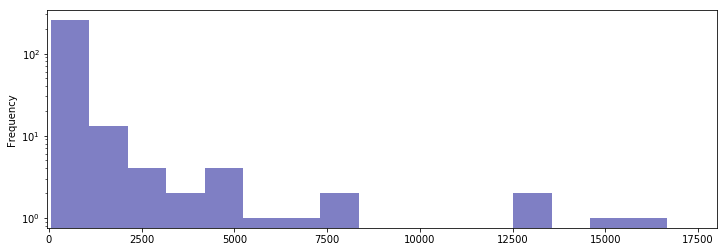

cluster 1
438


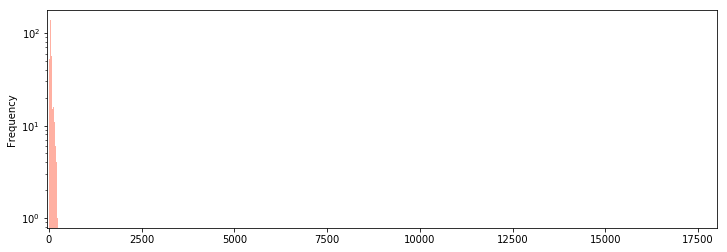

cluster 5
451


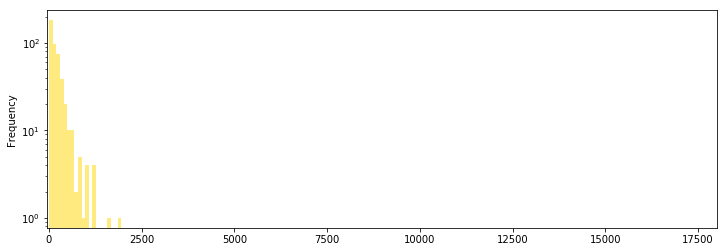

In [16]:
for i in som_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(som_sales_df[som_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    som_sales_df[som_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()
    f.savefig('images/som/som_cumulativesales_{}.png'.format(i))

In [17]:
for a, i in enumerate(som_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(som_sales_df[som_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


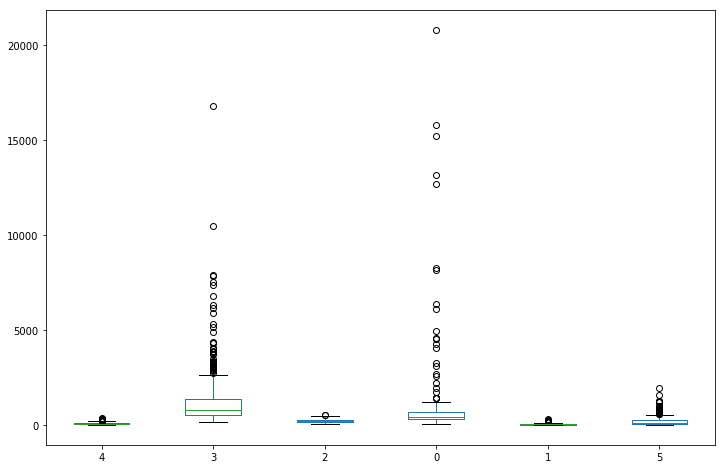

In [18]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)
f.savefig('images/som/som_cumulativesales_box.png')

In [20]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,4,119.0
1,4,122.0
3,4,44.0
6,4,62.0
11,4,37.0


In [21]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df          F        PR(>F)
cluster   5.337753e+07     1.0  56.566962  7.019791e-14
Residual  3.011081e+09  3191.0        NaN           NaN


In [22]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  0      1    -890.9324  -1079.7785 -702.0863   True 
  0      2    -723.2793  -911.8715  -534.6872   True 
  0      3     334.8205   148.0762   521.5648   True 
  0      4    -876.5065  -1041.1851  -711.828   True 
  0      5    -743.3833  -931.1511  -555.6154   True 
  1      2     167.6531    0.0828    335.2233   True 
  1      3    1225.7529  1060.2651  1391.2407   True 
  1      4     14.4259   -125.6876   154.5394  False 
  1      5     147.5492   -19.0928   314.1911  False 
  2      3    1058.0998   892.9018  1223.2978   True 
  2      4    -153.2272  -292.9983   -13.4561   True 
  2      5     -20.1039  -186.4581   146.2502  False 
  3      4    -1211.327  -1348.5946 -1074.0594  True 
  3      5    -1078.2037  -1242.46  -913.9474   True 
  4      5     133.1233   -5.5336    271.7801  False 
----------------------------

## t-SNE

In [88]:
tsne_clus = pd.read_csv('tsne_clusters.csv')
tsne_clus.columns = ['sku_key', 'cluster']

analyze_tsne = AnalyzeClusters()
df_dict = analyze_tsne.make_dataset(product_sales, tsne_clus)

In [89]:
len(tsne_clus['cluster'].unique())

8

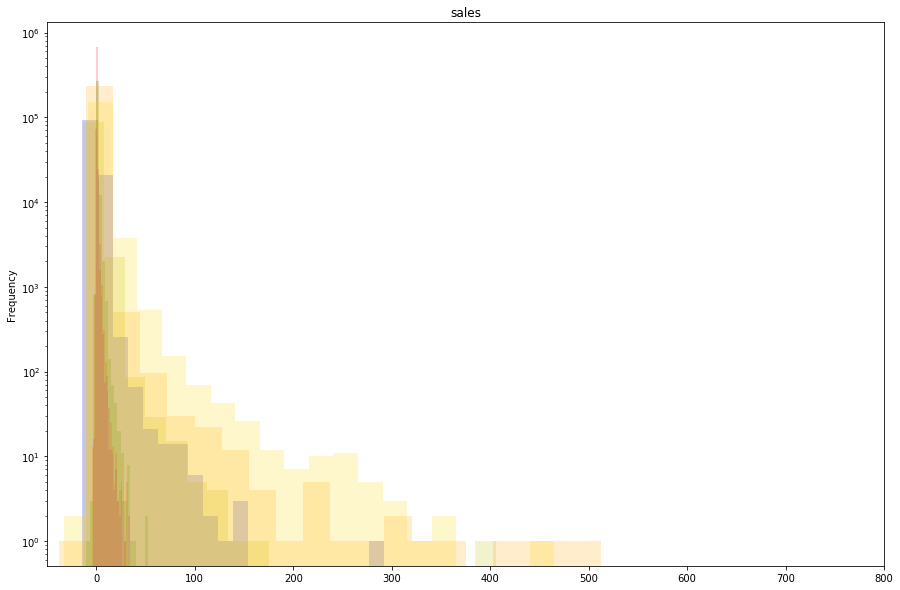

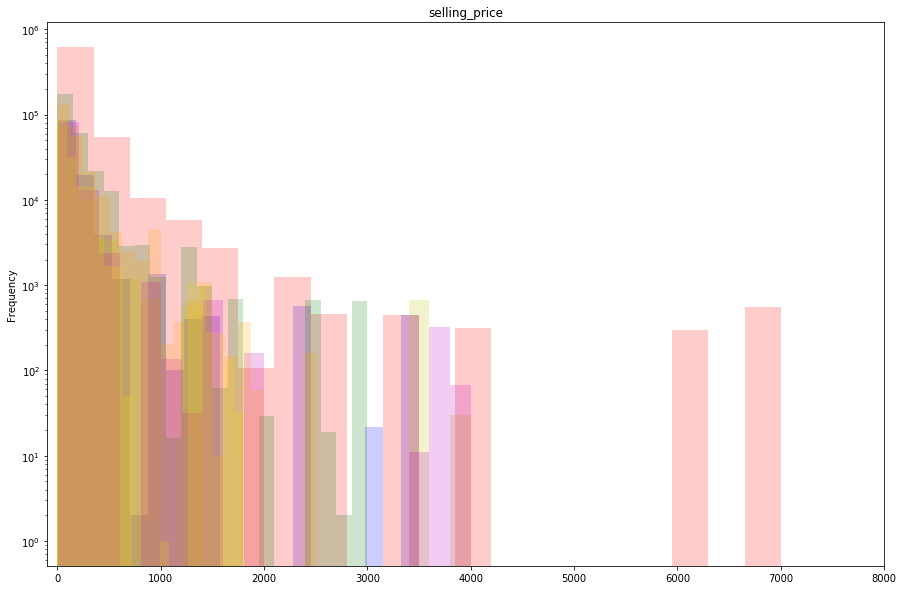

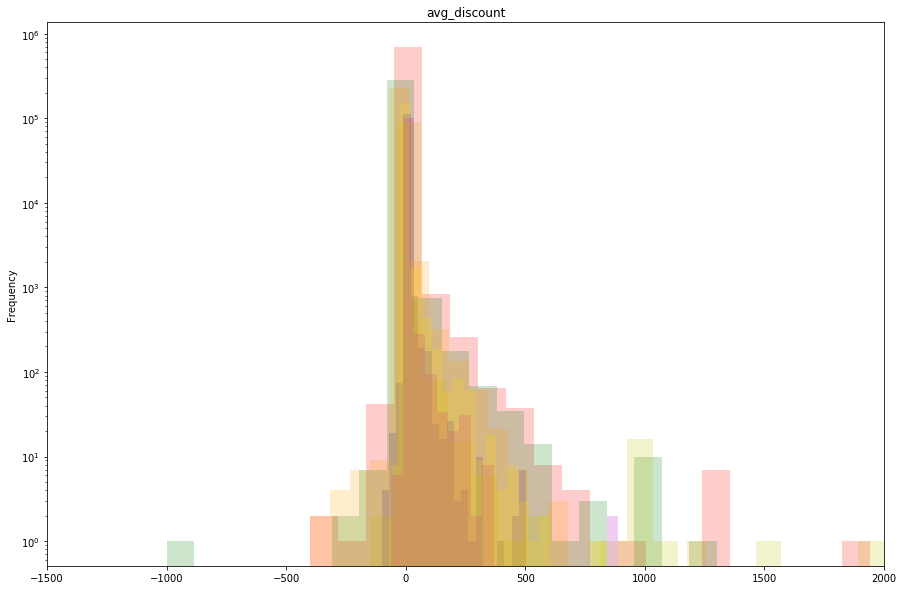

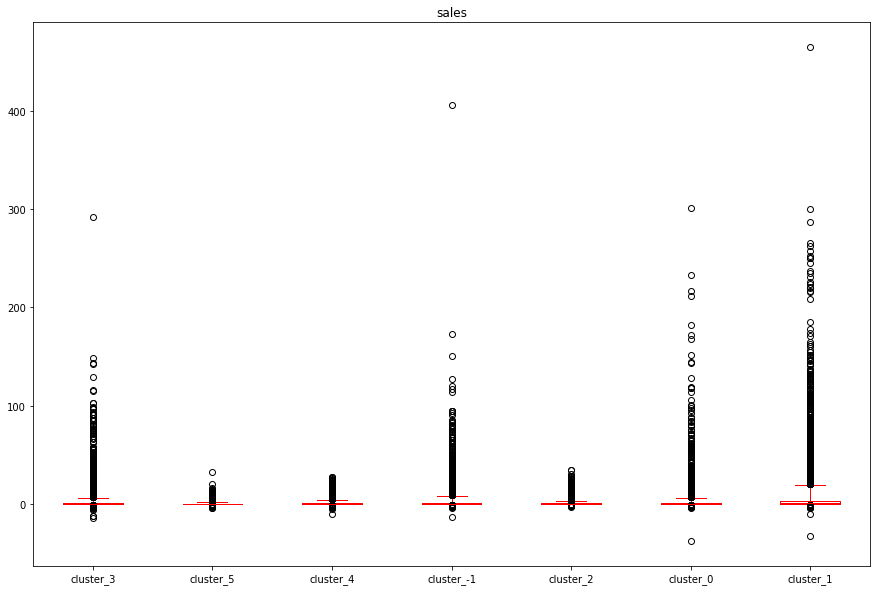

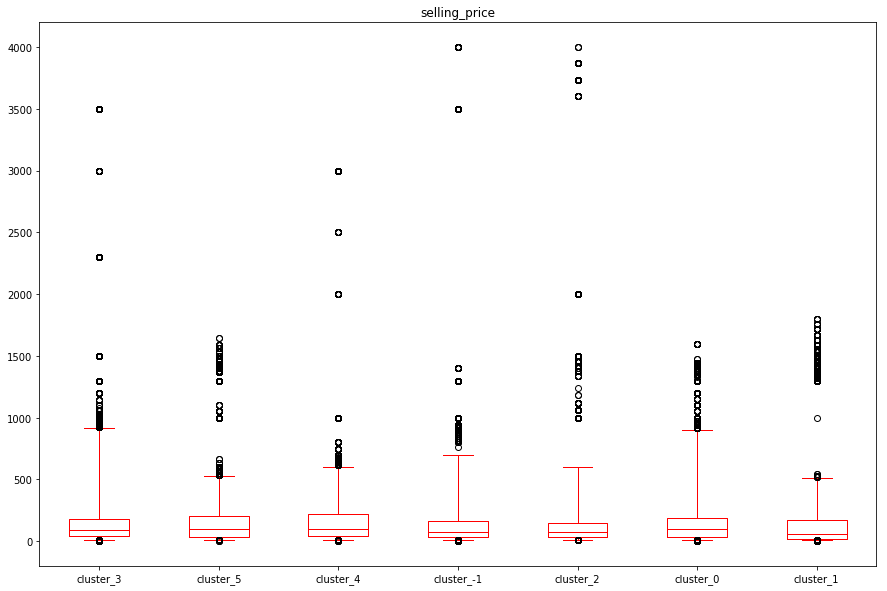

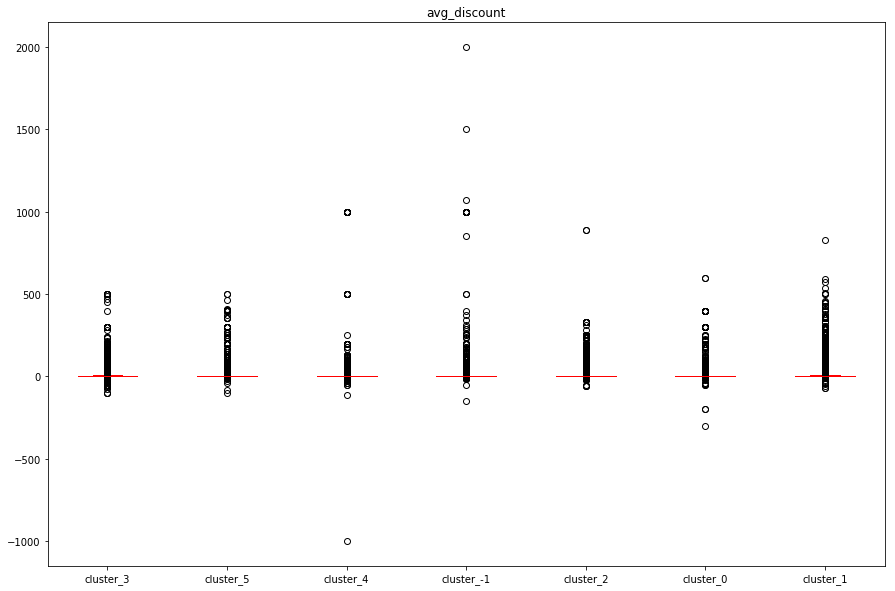

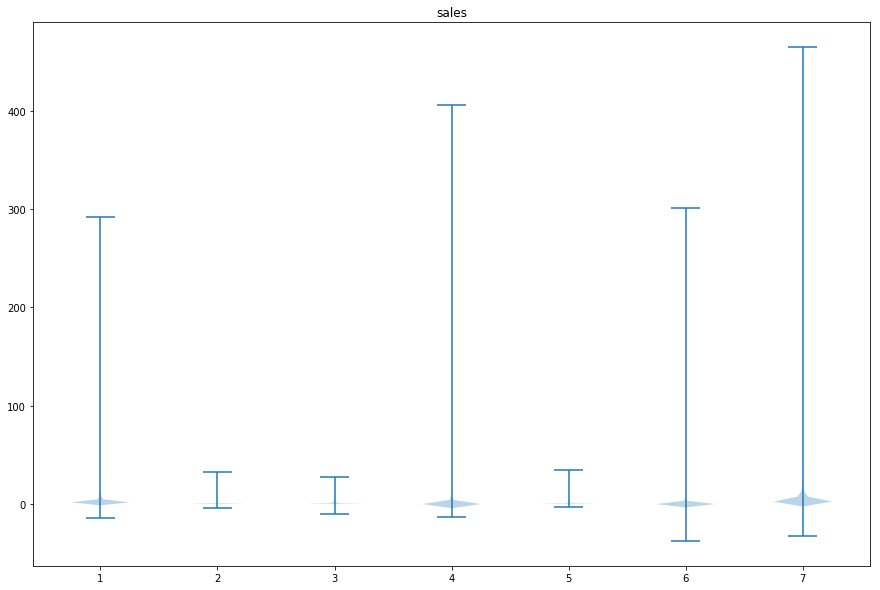

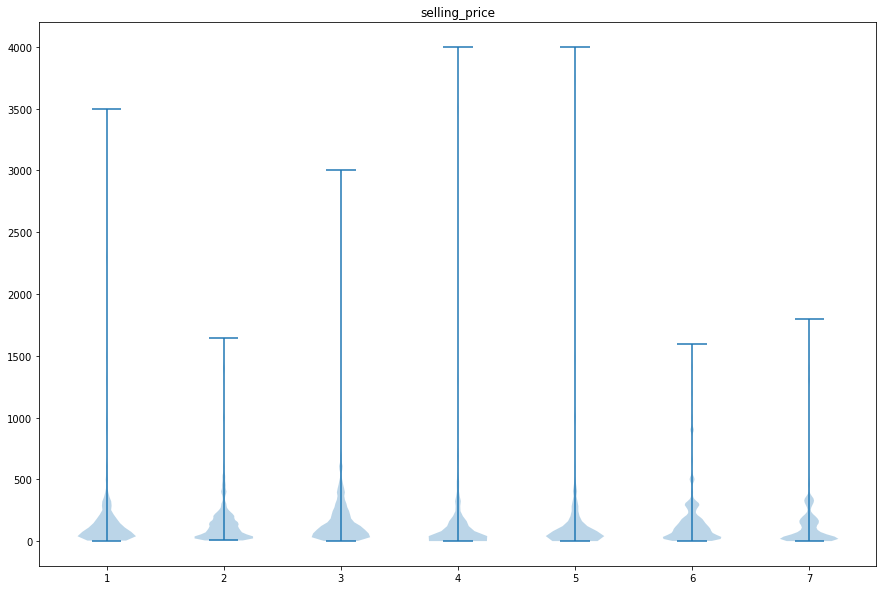

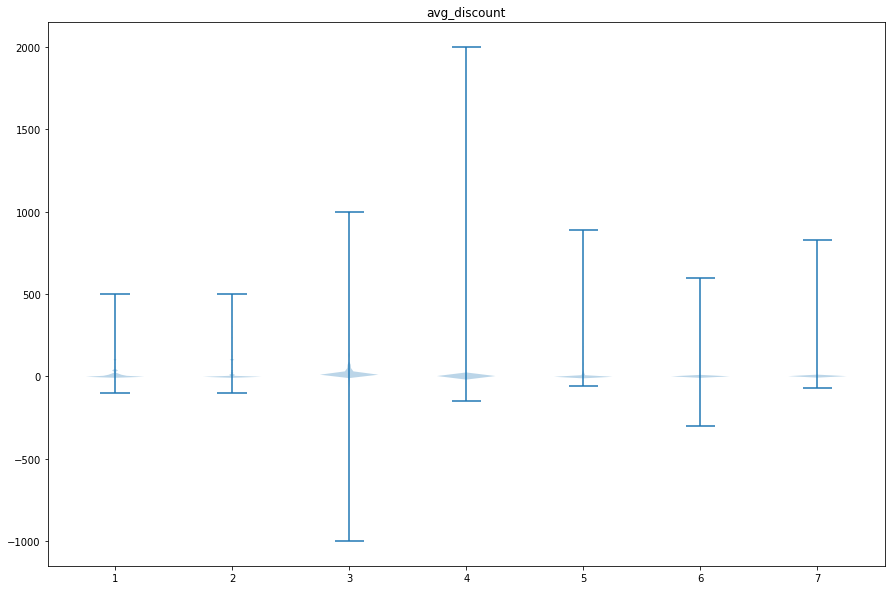



 sku_department


KeyError: 'sku_department'

In [63]:
analyze_tsne.plot_cluster_continuous(df_dict, run_cont, colors, True)
analyze_tsne.plot_cluster_continuous_box(df_dict, run_cont, True)
analyze_tsne.plot_cluster_continuous_violin(df_dict, run_cont, True)
analyze_tsne.plot_cluster_categorical(df_dict, run_cats, True)

In [ ]:
analyze_tsne.test_continuous_feat(df_dict, run_cont)

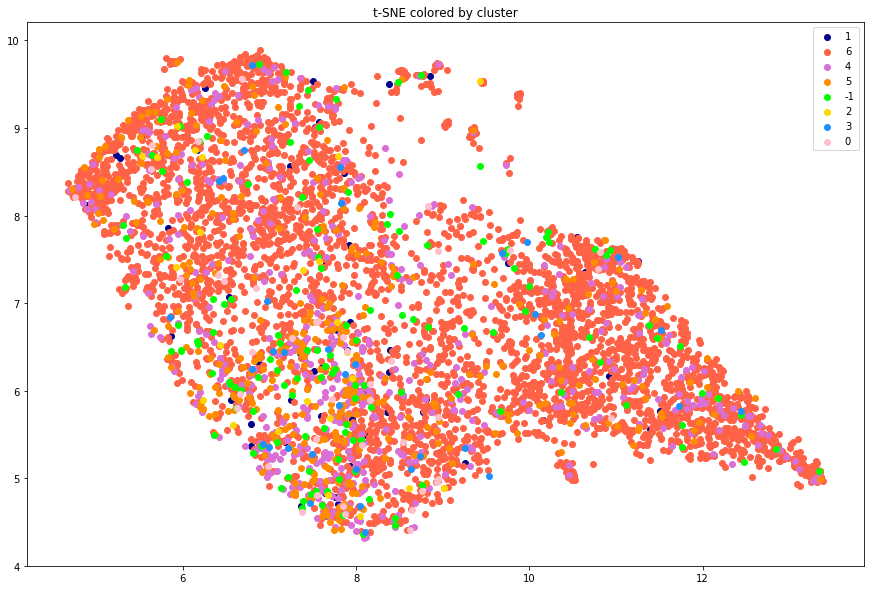

In [90]:
tsne_tsne = plot_df.merge(tsne_clus, left_on='id', right_on='sku_key')

plot_by_factor(tsne_tsne, 'cluster', colors, False)

In [189]:
tsne_sales_df = sales_df.merge(tsne_clus, on='sku_key')
tsne_sales_df.head()

,sku_key,sales,0,1,sales_log,cluster
0,28,119,21.035563,20.956148,2.075547,3
1,34,122,24.367508,23.636909,2.086360,5
2,100,1530,17.641212,16.045673,3.184691,4
3,152,44,27.642546,23.915024,1.643453,5
4,182,914,17.079857,20.009142,2.960946,-1


cluster 3
260


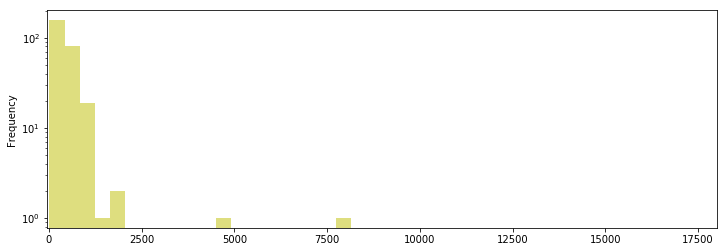

cluster 5
1249


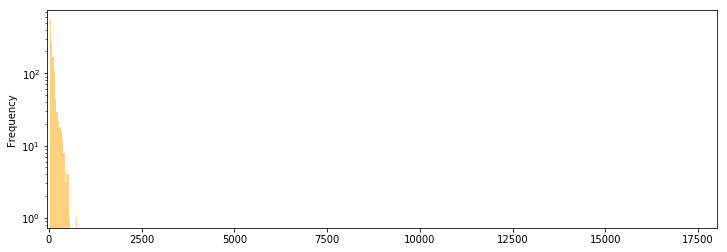

cluster 4
505


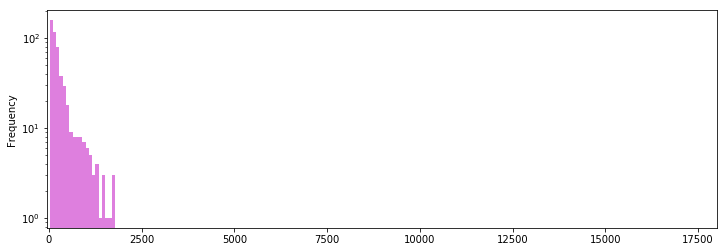

cluster -1
157


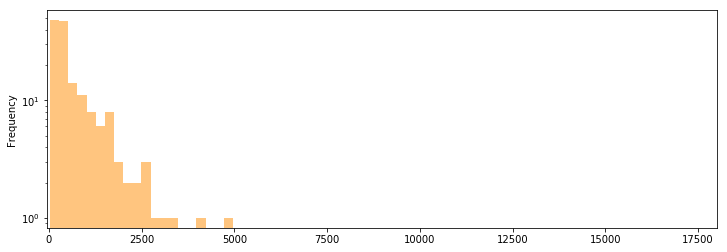

cluster 2
177


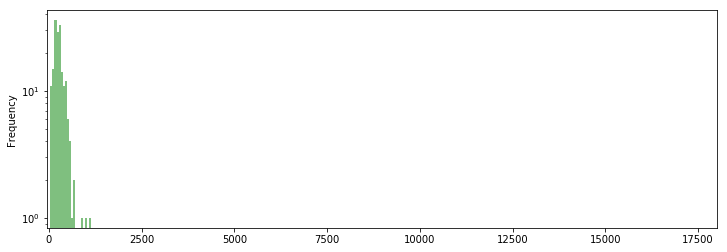

cluster 0
570


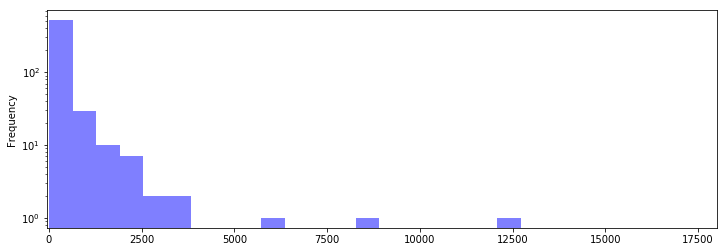

cluster 1
275


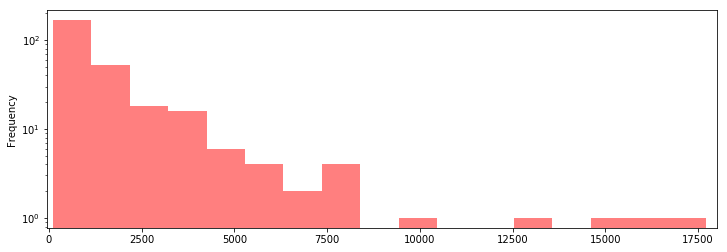

In [191]:
for i in tsne_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()
    #f.savefig('images/tsne/tsne_cumulativesales_{}.png'.format(i))

In [192]:
for a, i in enumerate(tsne_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(tsne_sales_df[tsne_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


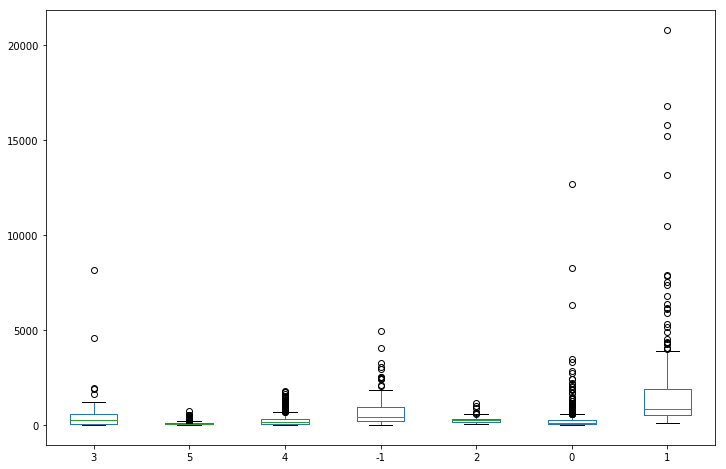

In [194]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)
#f.savefig('images/tsne/tsne_cumulativesales_box.png')

In [195]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,3,119.0
10,3,523.0
35,3,817.0
49,3,621.0
84,3,308.0


In [198]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df           F        PR(>F)
cluster   1.696380e+08     1.0  186.994238  2.070147e-41
Residual  2.894821e+09  3191.0         NaN           NaN


In [199]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

  Multiple Comparison of Means - Tukey HSD,FWER=0.05 
group1 group2  meandiff    lower      upper    reject
-----------------------------------------------------
  -1     0    -428.8208  -660.9105   -196.731   True 
  -1     1    1012.2506   754.6767  1269.8244   True 
  -1     2    -442.6477   -724.949  -160.3464   True 
  -1     3    -307.5322  -567.7922   -47.2721   True 
  -1     4    -439.7802  -675.0735  -204.4869   True 
  -1     5    -630.4046  -848.4453  -412.3638   True 
  0      1    1441.0713  1252.0109  1630.1317   True 
  0      2     -13.8269  -235.3976   207.7437  False 
  0      3     121.2886   -71.4155   313.9927  False 
  0      4     -10.9594  -168.3204   146.4016  False 
  0      5    -201.5838  -331.7427   -71.425    True 
  1      2    -1454.8983 -1703.0357 -1206.7608  True 
  1      3    -1319.7827 -1542.5236 -1097.0419  True 
  1      4    -1452.0307 -1645.0103 -1259.0512  True 
  1      5    -1642.6551 -1814.1776 -1471.1327  True 
  2      3     135.1155  -11

## Dynamic Time Warping

In [33]:
from scipy.cluster.hierarchy import dendrogram, fcluster
from dtaidistance import dtw, dtw_visualisation, clustering
from dtaidistance import dtw_visualisation as dtwvis
import pickle

In [34]:
model = pickle.load(open('model.pkl', 'rb'))

In [35]:
product_ts = pd.pivot_table(sales, values='sales',
                            index='sku_key', columns='tran_date')
product_ts['nas'] = product_ts.apply(lambda x: x.isna()).sum(axis=1)
product_ts = product_ts.sort_values('nas', ascending=True).drop('nas', axis=1)

In [36]:
threshold = 6
clusters = fcluster(model.linkage, threshold, criterion='inconsistent', depth=10)
dtw_df = product_ts.reset_index()
dtw_df['cluster'] = clusters
output_df = dtw_df[['sku_key', 'cluster']]
print('Outputting...')
output_df.to_csv('dtw_clusters.csv', index=False)

Outputting...


In [203]:
clusters_dtw = pd.read_csv('dtw_clusters.csv')
if clusters_dtw.columns[0] == 'Unnamed: 0':
    clusters_dtw.drop('Unnamed: 0', axis=1, inplace=True)
clusters_dtw.columns = ['sku_key', 'cluster']

In [205]:
len(clusters_dtw['cluster'].unique())

13

In [206]:
dtw_tsne = plot_df.merge(clusters_dtw, left_on='id', right_on='sku_key')

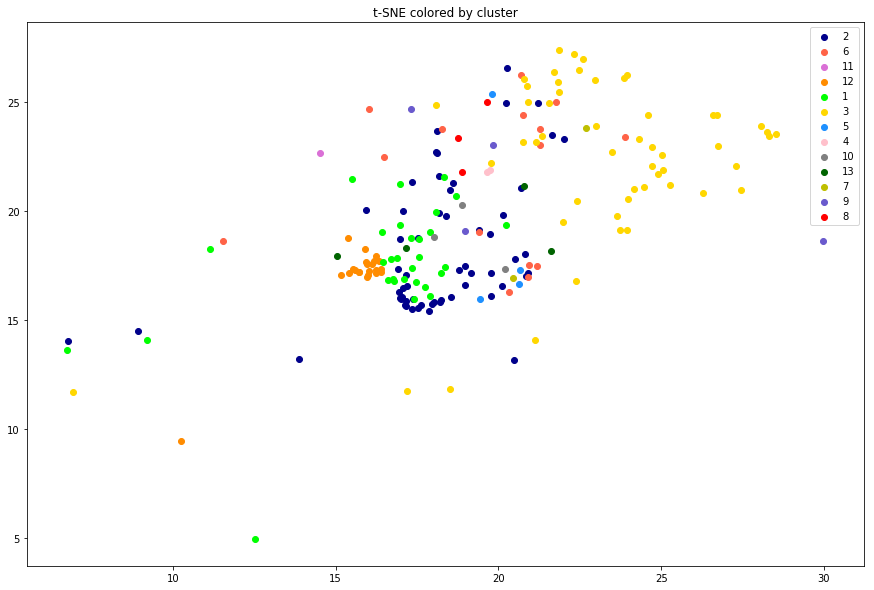

In [207]:
analyze_dtw = AnalyzeClusters()
df_dict = analyze_dtw.make_dataset(product_sales, clusters_dtw)

colors = ['darkblue', 'tomato', 'orchid', 'darkorange', 'lime', 'gold', 'dodgerblue', 'pink',
          'grey', 'darkgreen', 'y', 'slateblue', 'r', 'brown']

plot_by_factor(dtw_tsne, 'cluster', colors, False)



 sku_department


 sku_subdepartment


 sku_category


 sku_subcategory


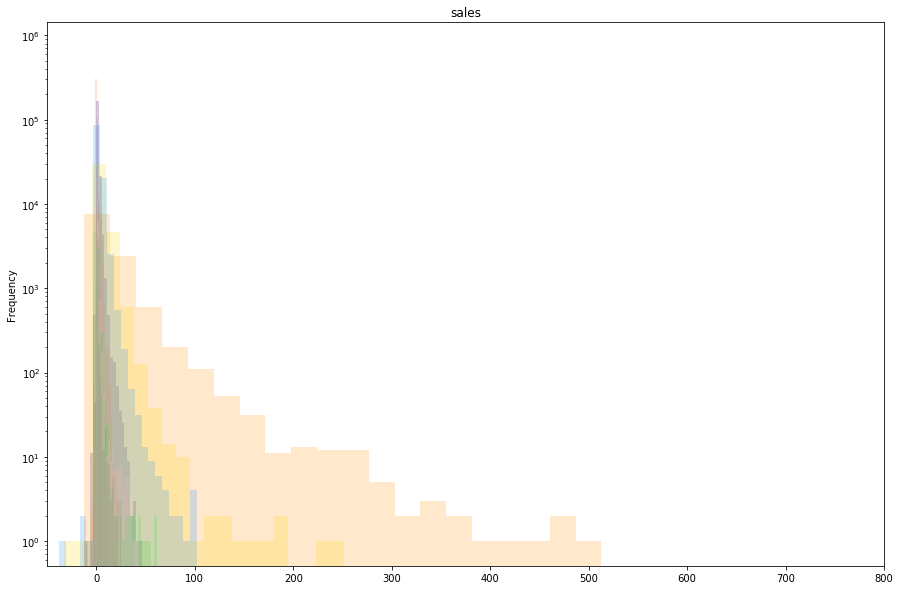

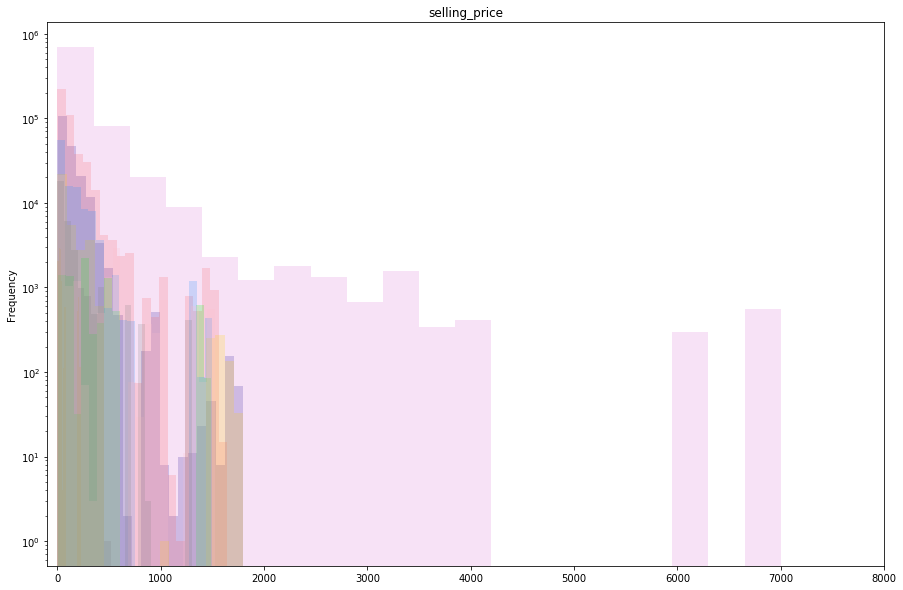

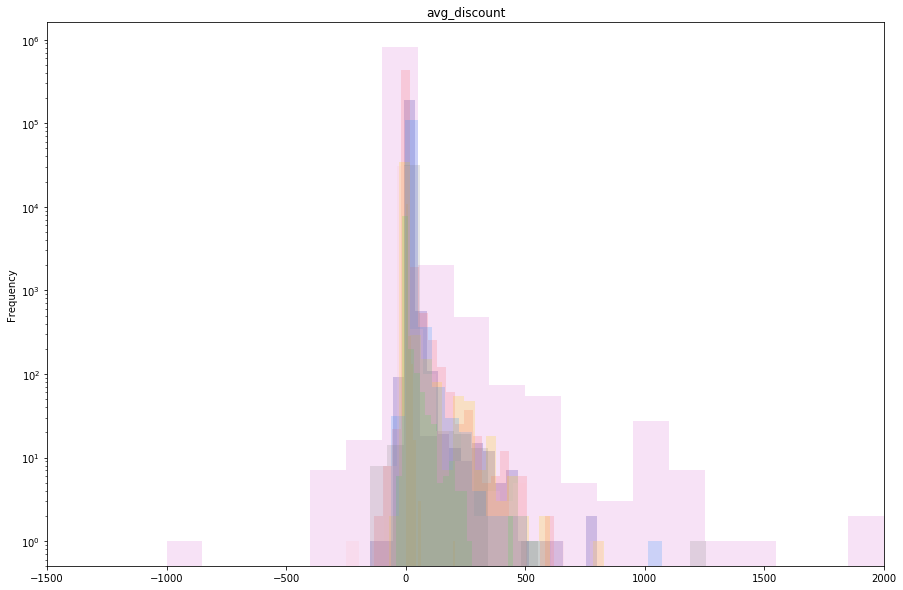

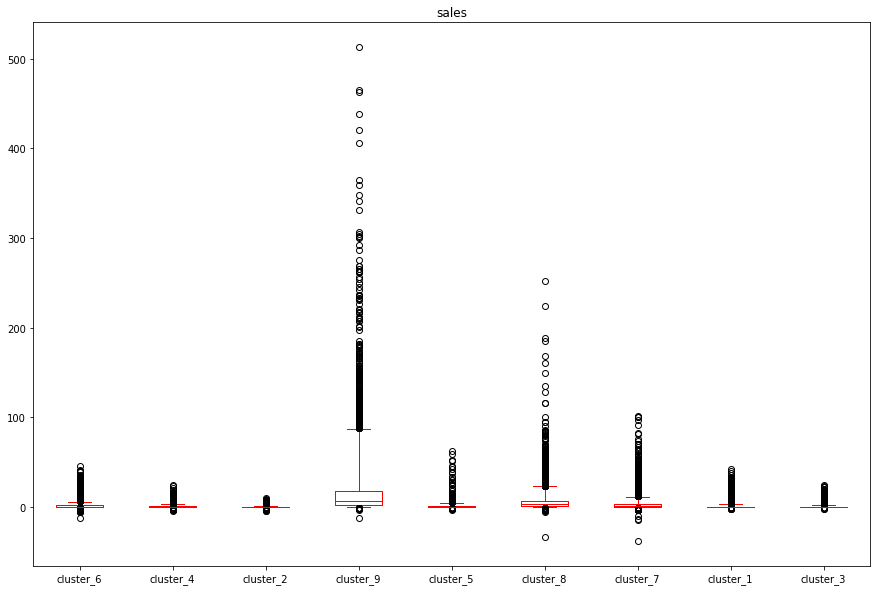

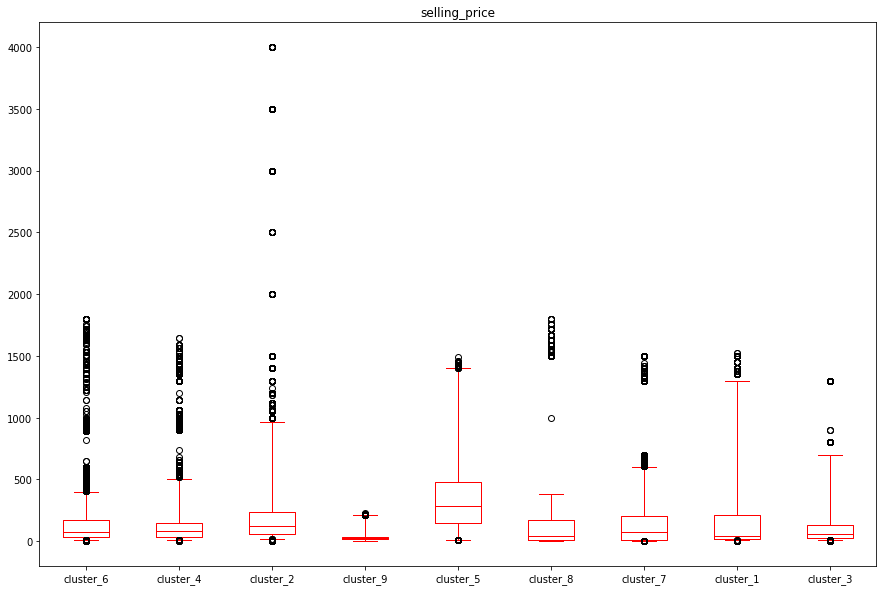

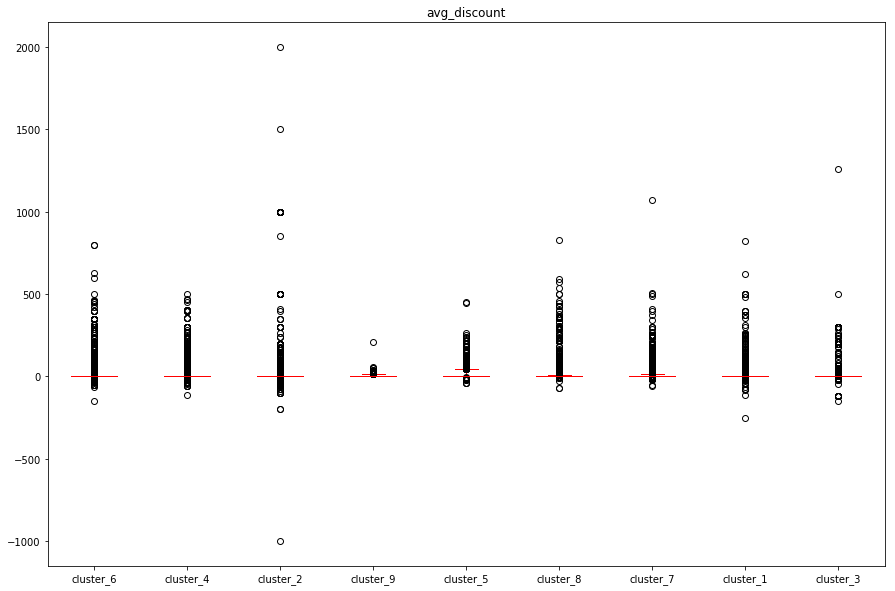

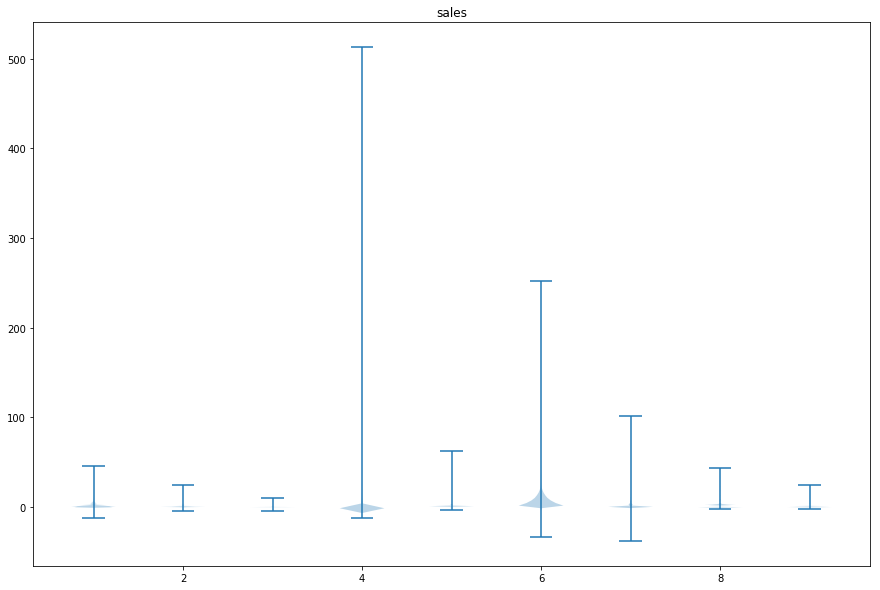

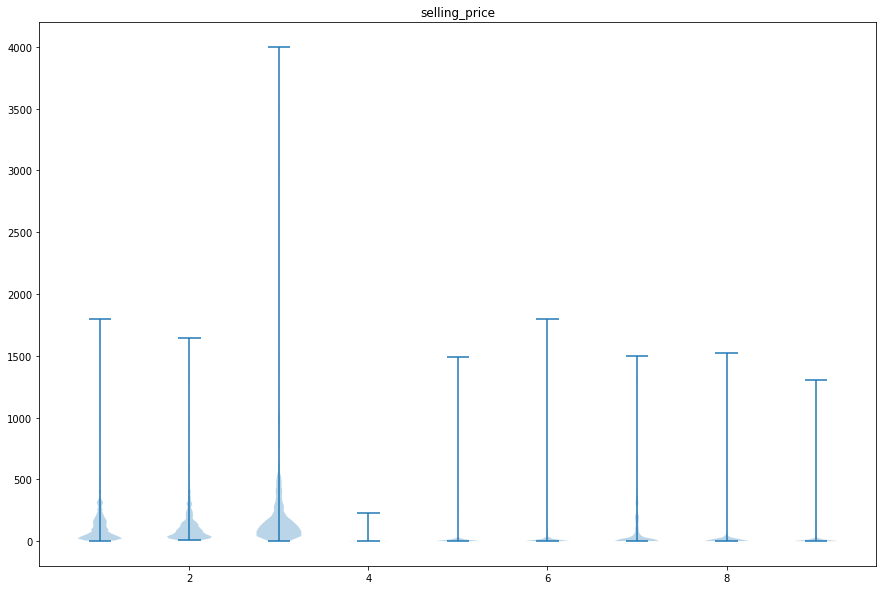

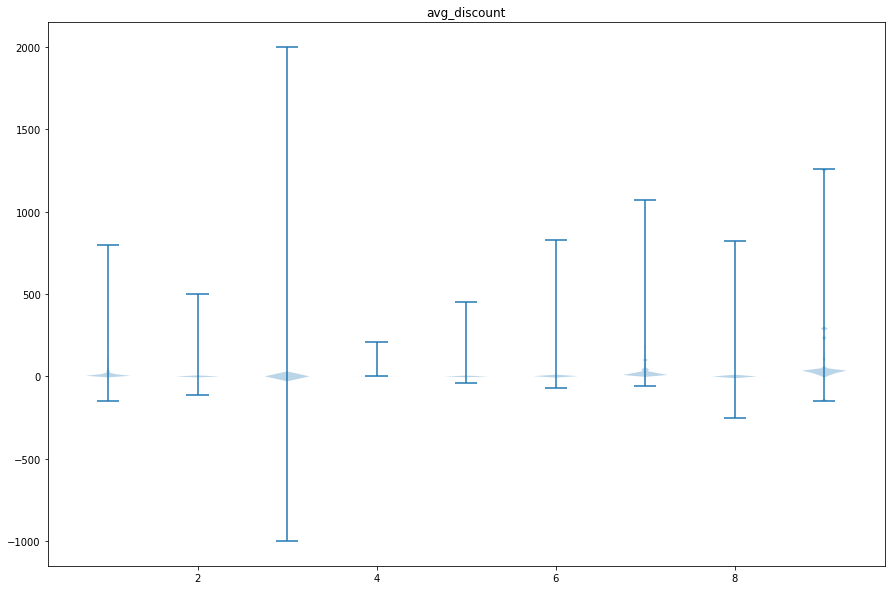

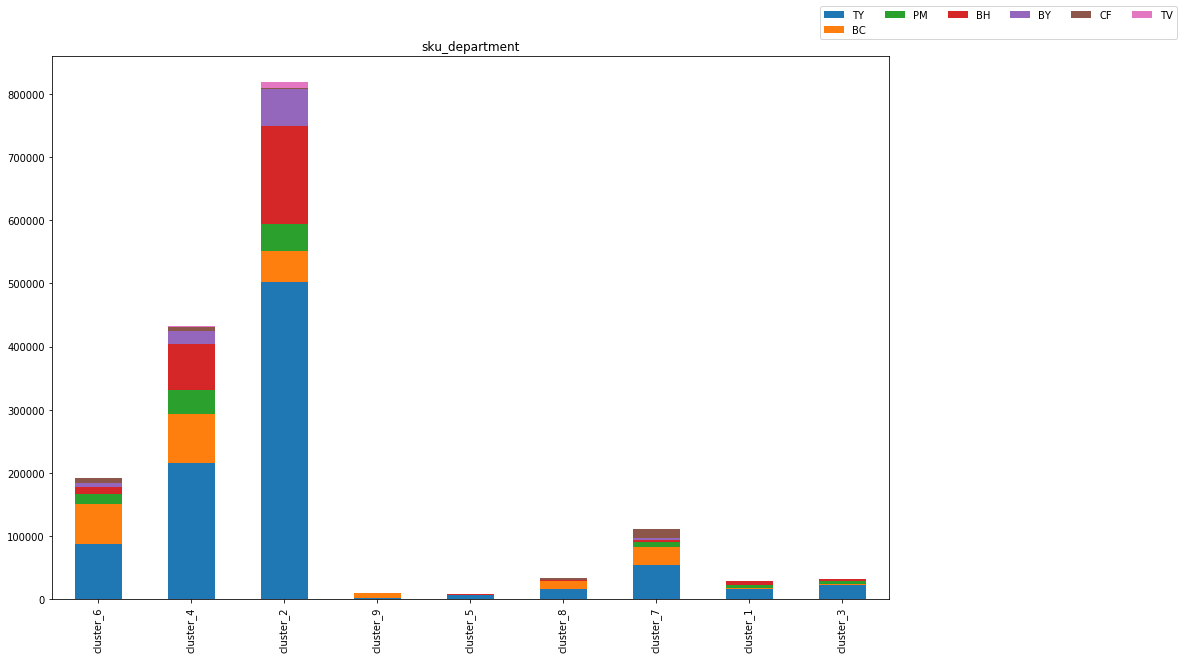

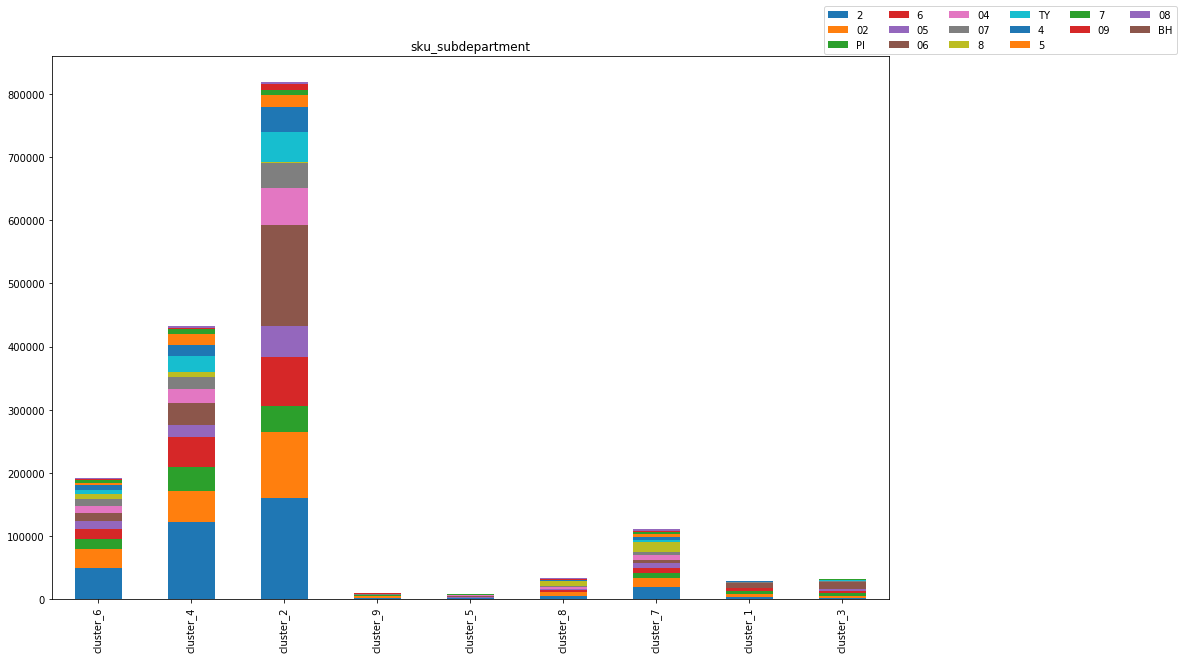

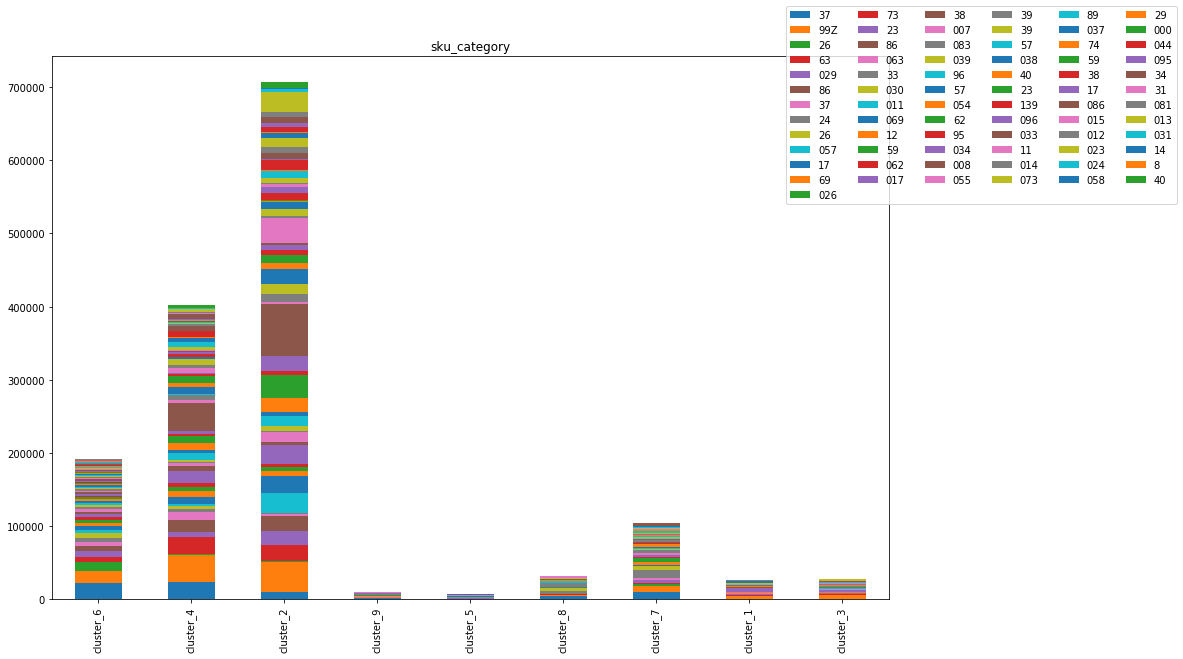

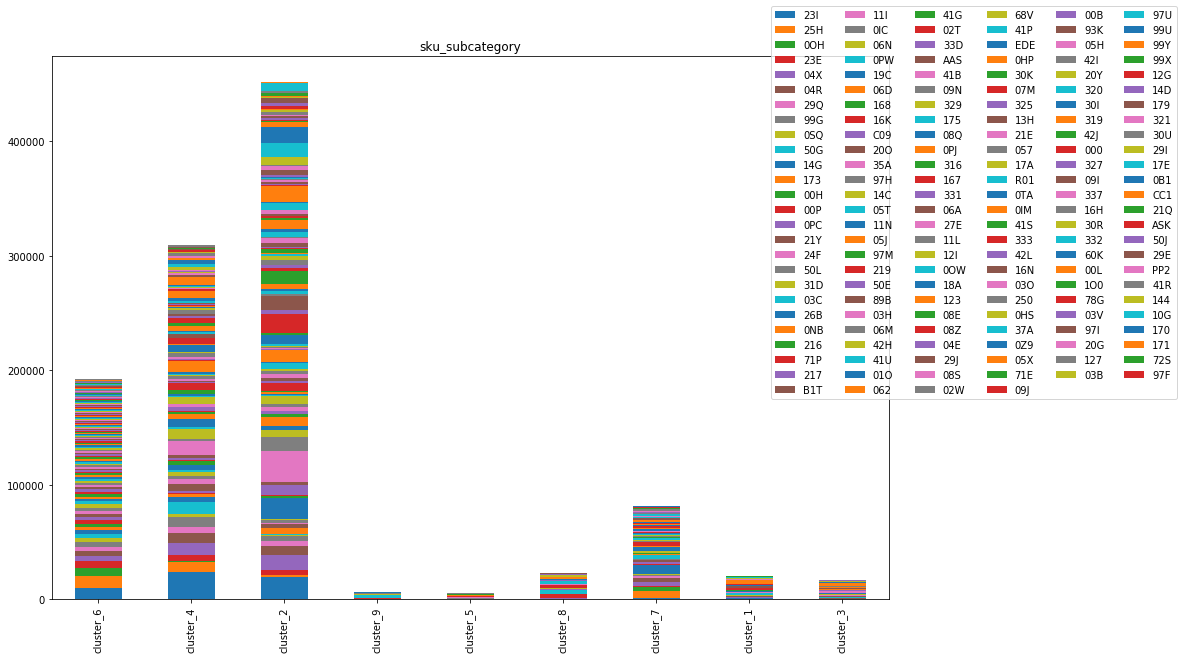

In [63]:
analyze_dtw.plot_cluster_continuous(df_dict, run_cont, colors, False)
analyze_dtw.plot_cluster_continuous_box(df_dict, run_cont, False)
analyze_dtw.plot_cluster_continuous_violin(df_dict, run_cont, False)
analyze_dtw.plot_cluster_categorical(df_dict, run_cats, False)

In [44]:
analyze_som.test_continuous_feat(df_dict, run_cont)


 
 sales
                sum_sq        df             F  PR(>F)
cluster   3.546965e+06       8.0  25696.462107     0.0
Residual  1.390548e+07  805921.0           NaN     NaN 

 Multiple Comparison of Means - Tukey HSD,FWER=0.05
  group1    group2  meandiff  lower   upper  reject
---------------------------------------------------
cluster_1 cluster_2 -0.2991   -0.378 -0.2202  True 
cluster_1 cluster_3 -0.2178  -0.3207  -0.115  True 
cluster_1 cluster_4  0.0553  -0.0236  0.1342 False 
cluster_1 cluster_5  0.4388   0.2788  0.5987  True 
cluster_1 cluster_6  0.6909   0.612   0.7698  True 
cluster_1 cluster_7  1.7886   1.7058  1.8714  True 
cluster_1 cluster_8  4.6355   4.5352  4.7358  True 
cluster_1 cluster_9 15.8826   15.74  16.0252  True 
cluster_2 cluster_3  0.0813   0.0033  0.1592  True 
cluster_2 cluster_4  0.3544   0.3128  0.3959  True 
cluster_2 cluster_5  0.7379   0.5927  0.883   True 
cluster_2 cluster_6   0.99    0.9484  1.0315  True 
cluster_2 cluster_7  2.0877   2.0391  2.136

In [45]:
dtw_sales_df = sales_df.merge(clusters_dtw, on='sku_key')
dtw_sales_df.head()

,sku_key,sales,0,1,class,sales_log,cluster
0,28,119,22.483915,25.307186,175,2.075547,4
1,34,122,18.813700,5.753131,175,2.086360,4
2,100,1530,-53.056255,13.143605,2000,3.184691,6
3,152,44,48.061001,-24.166861,25,1.643453,2
4,182,914,-25.316551,24.063744,775,2.960946,6


cluster 4
772


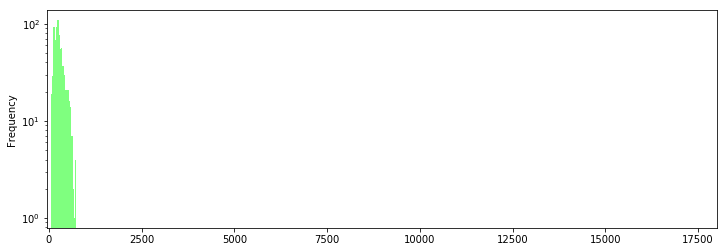

cluster 6
345


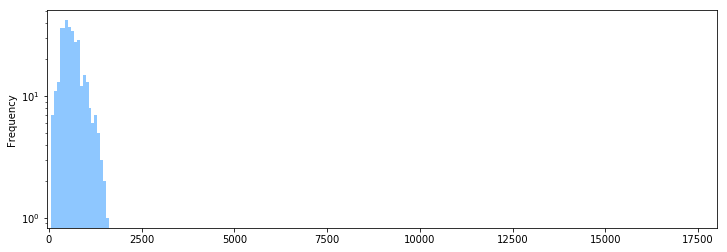

cluster 2
1677


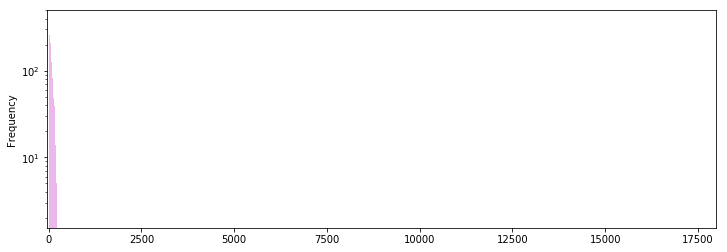

cluster 7
189


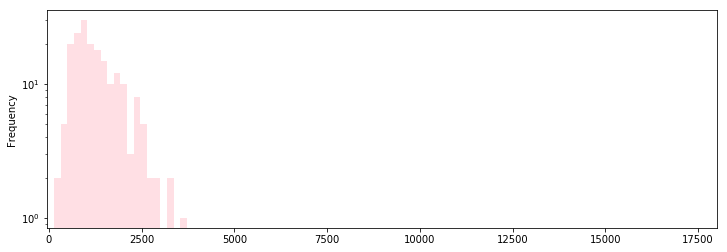

cluster 8
60


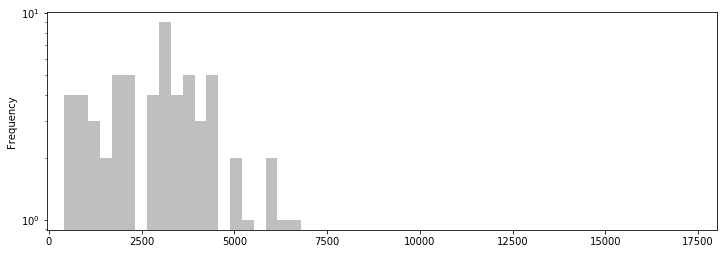

cluster 1
52


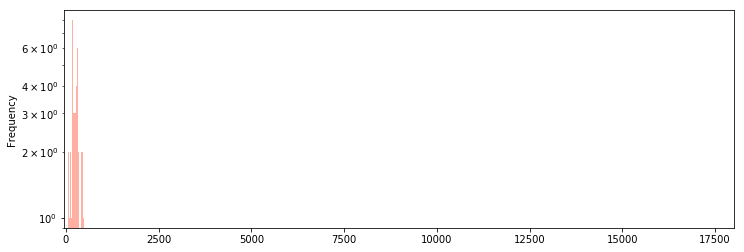

cluster 5
13


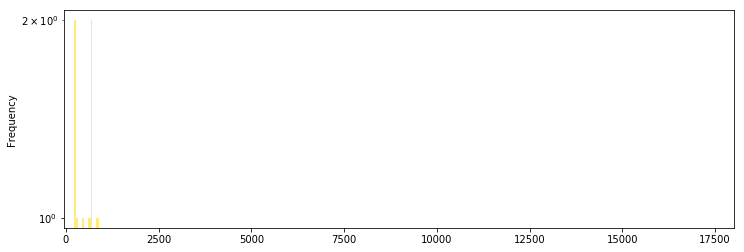

cluster 9
19


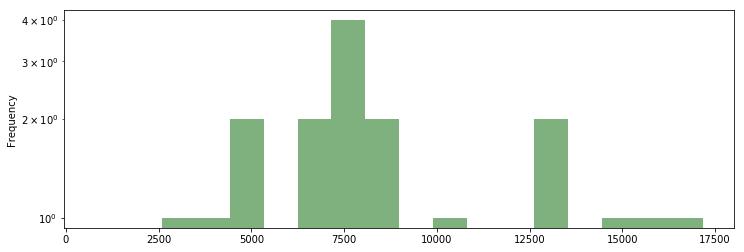

cluster 3
66


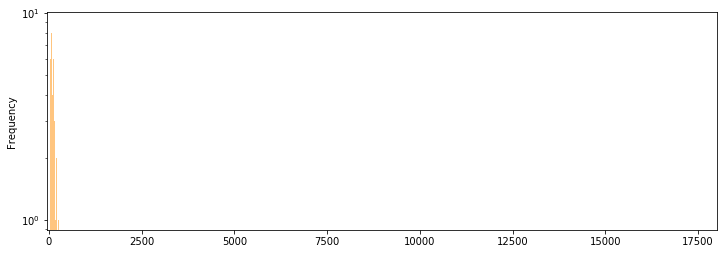

In [46]:
for i in dtw_sales_df['cluster'].unique():
    print('cluster {}'.format(i))
    print(len(dtw_sales_df[dtw_sales_df['cluster'] == i]['sales']))
    f, ax = plt.subplots(figsize=(12,4))
    dtw_sales_df[dtw_sales_df['cluster'] == i]['sales'].T.plot(kind='hist', color=colors[i], alpha=0.5, bins=20, ax=ax, logy=True)
    ax.set_xlim(-50, 18000)
    plt.show()
    f.savefig('images/dtw/dtw_cumulativesales_{}.png'.format(i))

In [47]:
for a, i in enumerate(dtw_sales_df['cluster'].unique()):
    if a == 0:
        int_df = pd.DataFrame(dtw_sales_df[dtw_sales_df['cluster'] == i]['sales'])
        int_df.columns = [i]
    else:
        temp = pd.DataFrame(dtw_sales_df[dtw_sales_df['cluster'] == i]['sales'])
        temp.columns = [i]
        int_df = int_df.join(temp, how='outer')


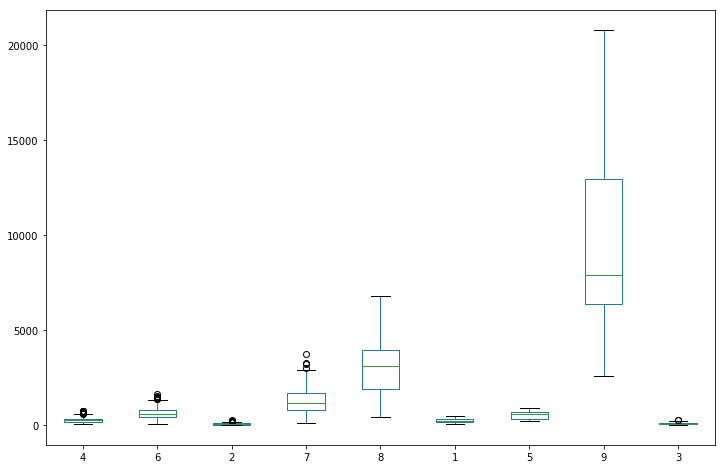

In [48]:
f, ax = plt.subplots(figsize=(12,8))
int_df.plot(kind='box', ax=ax)
f.savefig('images/dtw/dtw_cumulativesales_box.png')

In [49]:
int_df_unpiv = int_df.melt().dropna()
int_df_unpiv.columns = ['cluster', 'value']
int_df_unpiv.head()

,cluster,value
0,4,119.0
1,4,122.0
5,4,334.0
7,4,259.0
8,4,238.0


In [50]:
mod = ols('value ~ cluster',
                data=int_df_unpiv).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)


                sum_sq      df            F         PR(>F)
cluster   1.003551e+09     1.0  1553.844365  3.127023e-277
Residual  2.060908e+09  3191.0          NaN            NaN


In [51]:
print(pairwise_tukeyhsd(int_df_unpiv['value'], int_df_unpiv['cluster']))

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower     upper   reject
--------------------------------------------------
  1      2    -188.6047 -394.7226  17.5133  False 
  1      3    -153.5816 -425.0092  117.846  False 
  1      4     22.6167  -187.1033  232.3367 False 
  1      5     293.0769 -160.8333  746.9871 False 
  1      6     369.2994  151.5432  587.0557  True 
  1      7      1049.7   820.4747 1278.9253  True 
  1      8    2729.0821 2451.7383 3006.4258  True 
  1      9    9268.1943 8875.7868 9660.6018  True 
  2      3     35.0231  -148.6717  218.7178 False 
  2      4     211.2213  147.5556  274.8871  True 
  2      5     481.6816  74.1214   889.2418  True 
  2      6     557.9041  471.3672  644.4409  True 
  2      7    1238.3047 1125.9878 1350.6216  True 
  2      8    2917.6867 2725.3579 3110.0155  True 
  2      9     9456.799 9119.0794 9794.5185  True 
  3      4     176.1983  -11.5293  363.9258 False 
  3      5     446.6585   2.481